<a href="https://colab.research.google.com/github/Revanth21211458/Analyzing-Sentiment-in-Twitter-for-Stock-Market-Trends/blob/main/IIT_Roorkee_EEG_DL_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading Packages

In [1]:
!pip install torch
!pip install scikit-learn
!pip install mne
!pip install torch
!pip install tensorflow
!pip install pytorch-lightning
!pip install matplotlib
!pip install pyedflib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

#1.Load the EEG Data

In [2]:
import mne
import numpy as np
import os
import torch
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
# Connecting colab with drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


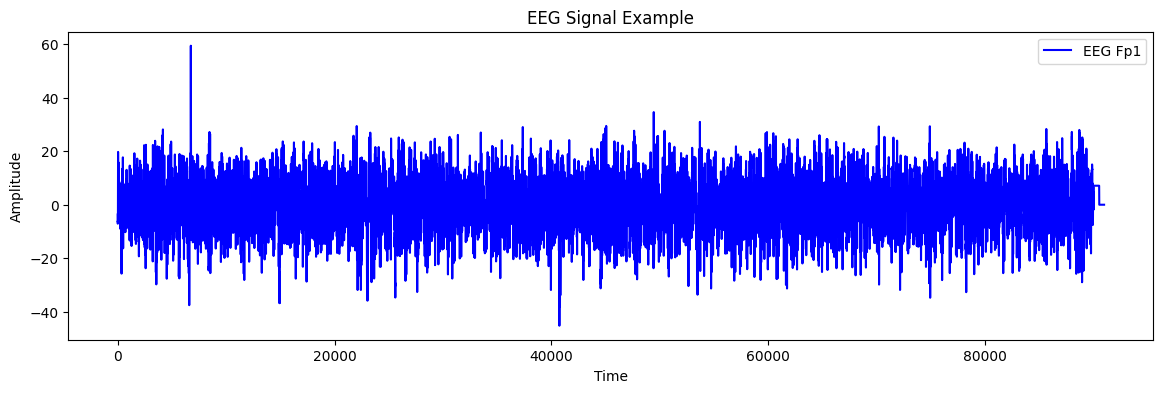

In [4]:
import matplotlib.pyplot as plt
import pyedflib

# Path of the data set in drive
data_path = '/content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0'

# Path to the Subject00_1.edf
edf_file = data_path + '/Subject00_1.edf'

# Creating an EdfReader object
edf_reader = pyedflib.EdfReader(edf_file)

# Get the basic information about the signals in the .edf file
n_channels = edf_reader.signals_in_file
channel_labels = edf_reader.getSignalLabels()
sampling_freq = edf_reader.getSampleFrequency(0)  # Assuming all channels have the same sampling frequency

# Reading signals from the file
signals = []
for i in range(n_channels):
    signals.append(edf_reader.readSignal(i))
signals = np.array(signals)

# Closing the EdfReader
edf_reader.close()

# Plotting the  example signal (assuming you have one channel)
plt.figure(figsize=(14, 4))
plt.plot(signals[0], color='b', label=channel_labels[0])
plt.title('EEG Signal Example')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#2a. Power Spectral Density Analysis:

In [5]:
# Importing libraries
import pyedflib
from scipy.signal import welch
import numpy as np

# Defining function to compute band-wise PSD
def compute_band_psd(edf_file):
    try:
        # Opening the EDF file
        f = pyedflib.EdfReader(edf_file)

        # Getting number of signals (channels)
        n_signals = f.signals_in_file

        # Assuming EEG is in the first channel (adjust if necessary)
        signal = f.readSignal(0)
        fs = f.getSampleFrequency(0)

        # Closeing the file
        f.close()

        # Computing PSD using Welch's method
        frequencies, psd = welch(signal, fs=fs, nperseg=256)

        # Defining frequency bands
        delta_band = (frequencies >= 1) & (frequencies <= 4)
        theta_band = (frequencies >= 4) & (frequencies <= 8)
        alpha_band = (frequencies >= 8) & (frequencies <= 12)
        beta_band = (frequencies >= 12) & (frequencies <= 30)
        gamma_band = (frequencies >= 30) & (frequencies <= 100)

        # Computing average power in each band
        delta_power = np.mean(psd[delta_band])
        theta_power = np.mean(psd[theta_band])
        alpha_power = np.mean(psd[alpha_band])
        beta_power = np.mean(psd[beta_band])
        gamma_power = np.mean(psd[gamma_band])

        return delta_power, theta_power, alpha_power, beta_power, gamma_power

    except Exception as e:
        print(f"Error processing {edf_file}: {e}")
        return None, None, None, None, None

# Defining the path to the dataset on Google Drive
data_path = '/content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0'

# Listing of EDF files to process
edf_files = []

# Generating list of files from 'Subject00_1.edf' to 'Subject35_2.edf'
for subject in range(36):  # Subjects 00 to 35
    edf_files.append((
        f'{data_path}/Subject{subject:02}_1.edf',  # Rest state
        f'{data_path}/Subject{subject:02}_2.edf'   # Task state
    ))

# Dictionary to store band-wise PSD results
band_psd_results = {}

# Compute band-wise PSD for each subject
for rest_file, task_file in edf_files:
    # Compute band-wise PSD for rest state
    delta_rest, theta_rest, alpha_rest, beta_rest, gamma_rest = compute_band_psd(rest_file)

    # Compute band-wise PSD for task state
    delta_task, theta_task, alpha_task, beta_task, gamma_task = compute_band_psd(task_file)

    # Store results in dictionary
    subject_id = rest_file.split("/")[-1][:9]
    band_psd_results[subject_id] = {
        'Rest': {'Delta': delta_rest, 'Theta': theta_rest, 'Alpha': alpha_rest, 'Beta': beta_rest, 'Gamma': gamma_rest},
        'Task': {'Delta': delta_task, 'Theta': theta_task, 'Alpha': alpha_task, 'Beta': beta_task, 'Gamma': gamma_task}
    }

# Print band-wise PSD results
for subject_id, data in band_psd_results.items():
    print(f'Subject {subject_id}:')
    print('Rest State:')
    print(f"  Delta Power: {data['Rest']['Delta']:.4f}")
    print(f"  Theta Power: {data['Rest']['Theta']:.4f}")
    print(f"  Alpha Power: {data['Rest']['Alpha']:.4f}")
    print(f"  Beta Power: {data['Rest']['Beta']:.4f}")
    print(f"  Gamma Power: {data['Rest']['Gamma']:.4f}")
    print('Task State:')
    print(f"  Delta Power: {data['Task']['Delta']:.4f}")
    print(f"  Theta Power: {data['Task']['Theta']:.4f}")
    print(f"  Alpha Power: {data['Task']['Alpha']:.4f}")
    print(f"  Beta Power: {data['Task']['Beta']:.4f}")
    print(f"  Gamma Power: {data['Task']['Gamma']:.4f}")
    print()


Subject Subject00:
Rest State:
  Delta Power: 4.2228
  Theta Power: 2.5391
  Alpha Power: 7.6510
  Beta Power: 0.7720
  Gamma Power: 0.0156
Task State:
  Delta Power: 17.2517
  Theta Power: 3.7168
  Alpha Power: 8.7269
  Beta Power: 1.1897
  Gamma Power: 0.0398

Subject Subject01:
Rest State:
  Delta Power: 3.1401
  Theta Power: 2.7035
  Alpha Power: 2.5303
  Beta Power: 0.6451
  Gamma Power: 0.0232
Task State:
  Delta Power: 12.0571
  Theta Power: 7.9679
  Alpha Power: 3.0034
  Beta Power: 0.6597
  Gamma Power: 0.0444

Subject Subject02:
Rest State:
  Delta Power: 3.6785
  Theta Power: 2.1198
  Alpha Power: 3.7875
  Beta Power: 2.5712
  Gamma Power: 0.2635
Task State:
  Delta Power: 3.7181
  Theta Power: 1.6125
  Alpha Power: 2.1112
  Beta Power: 1.8578
  Gamma Power: 0.2160

Subject Subject03:
Rest State:
  Delta Power: 8.7867
  Theta Power: 3.6474
  Alpha Power: 4.8846
  Beta Power: 0.5687
  Gamma Power: 0.0259
Task State:
  Delta Power: 7.5123
  Theta Power: 1.6593
  Alpha Power: 1

#2b. Compare the PSDs of the two states and findings.

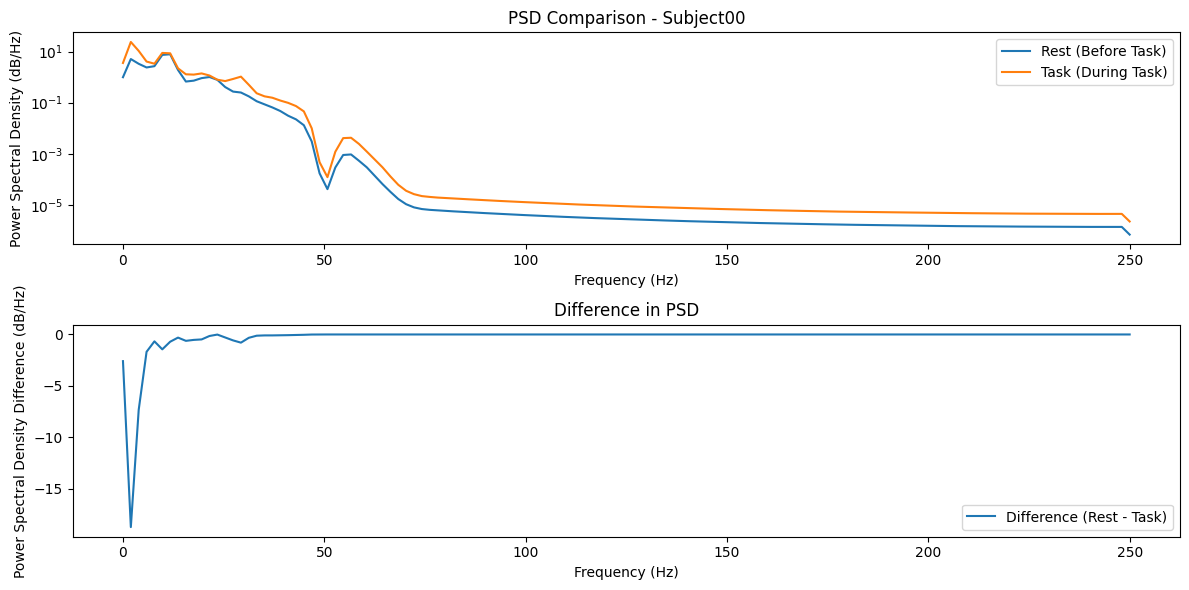

Subject00: Avg Power Before = 0.2893704726475055, Avg Power During = 0.5823206877073905


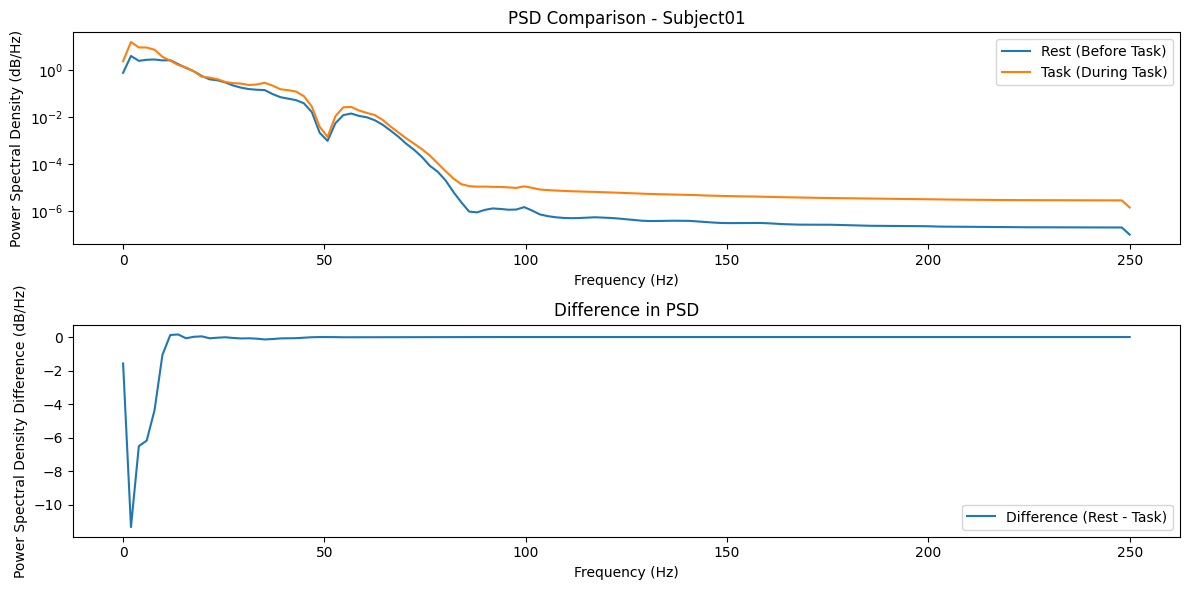

Subject01: Avg Power Before = 0.18708150887220795, Avg Power During = 0.43346020181071115


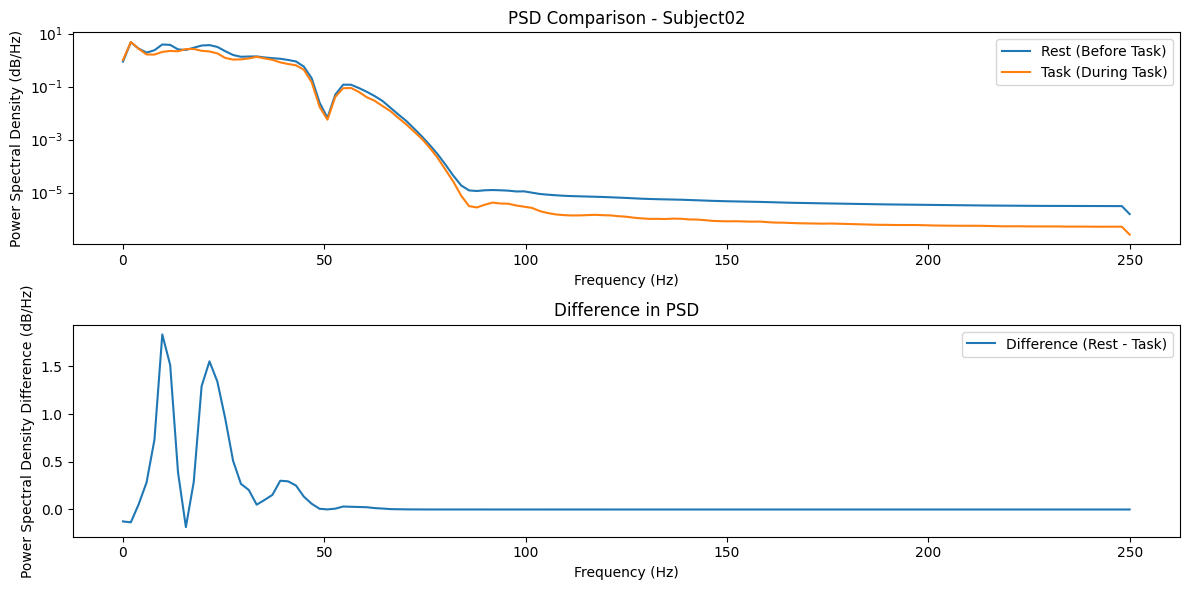

Subject02: Avg Power Before = 0.4083130702905939, Avg Power During = 0.31301099209935573


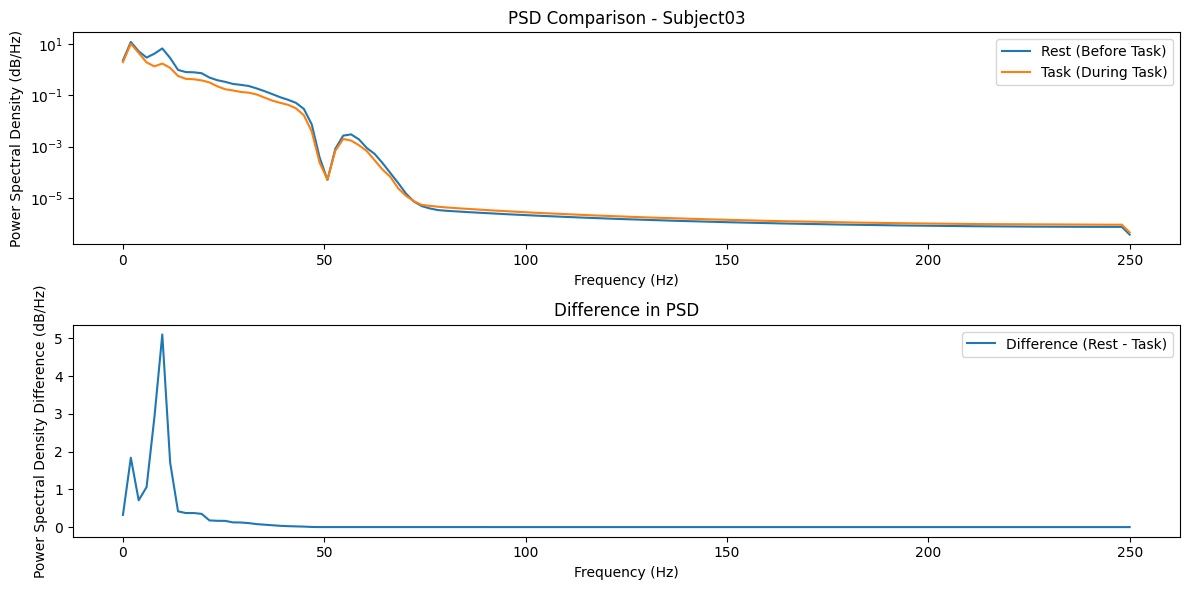

Subject03: Avg Power Before = 0.333526069127028, Avg Power During = 0.20695750531894624


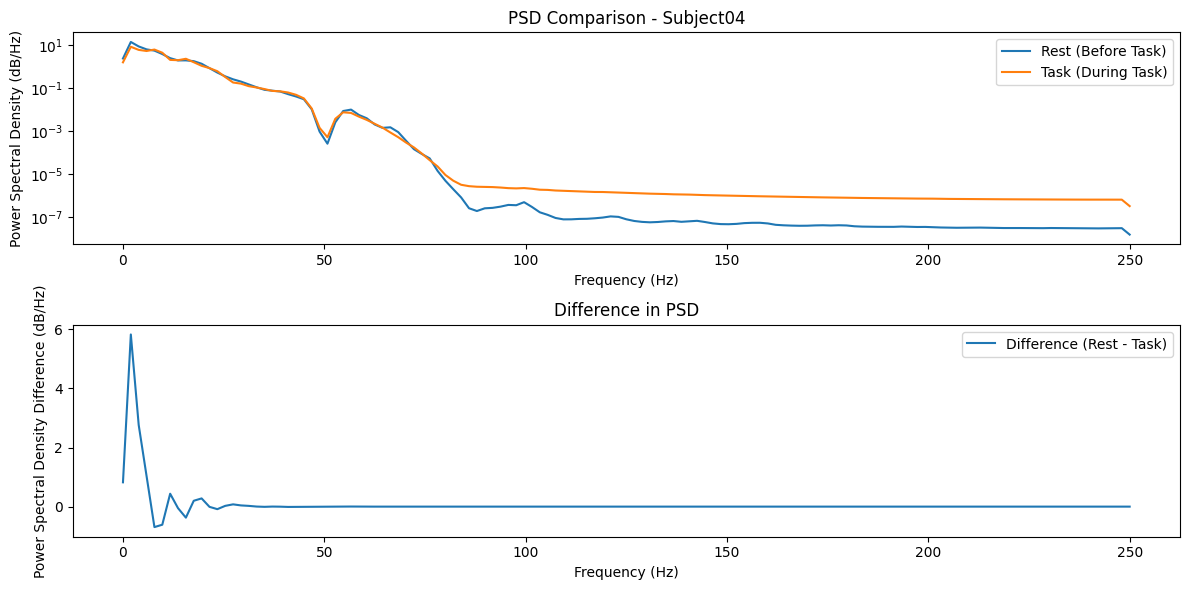

Subject04: Avg Power Before = 0.4246642730350006, Avg Power During = 0.34964266645799735


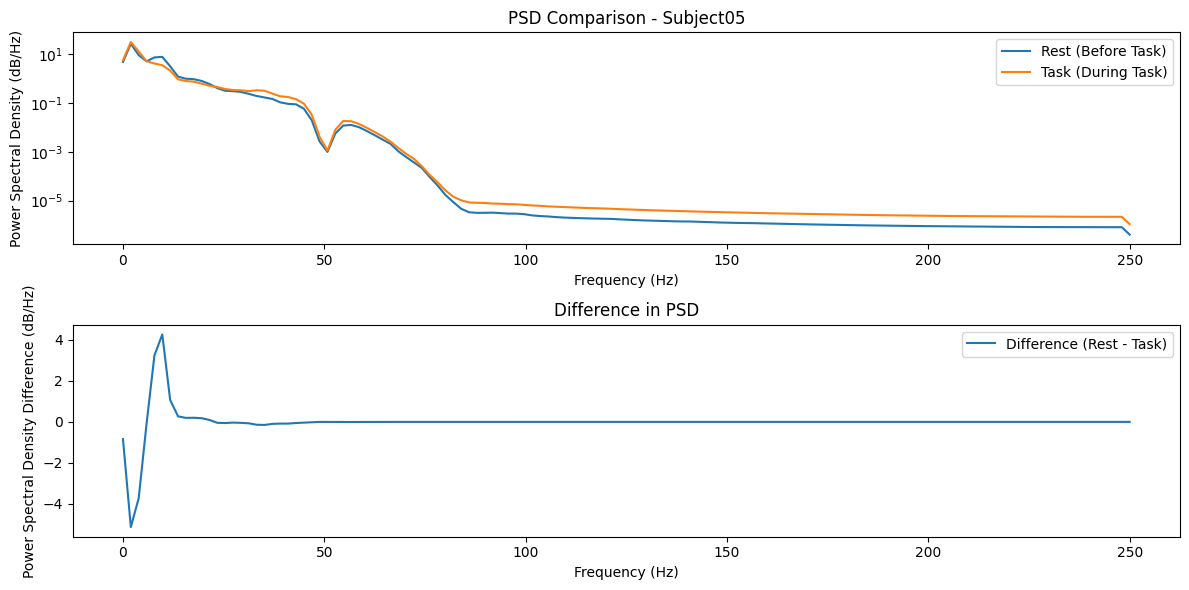

Subject05: Avg Power Before = 0.5541351609897766, Avg Power During = 0.5634630468037357


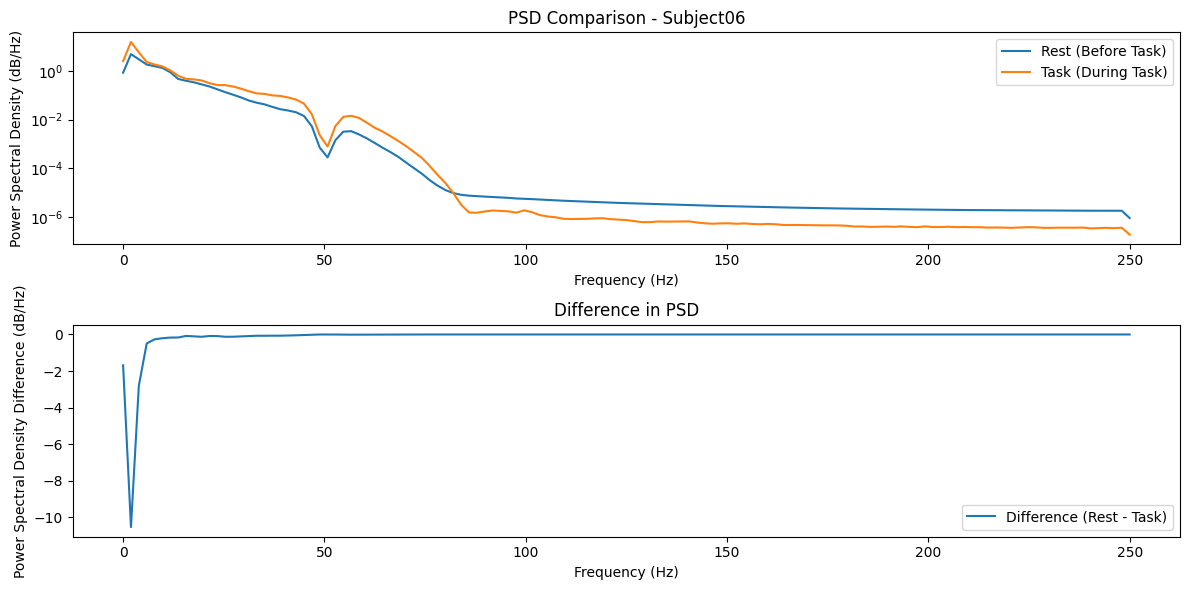

Subject06: Avg Power Before = 0.13060840196079726, Avg Power During = 0.2680974504169435


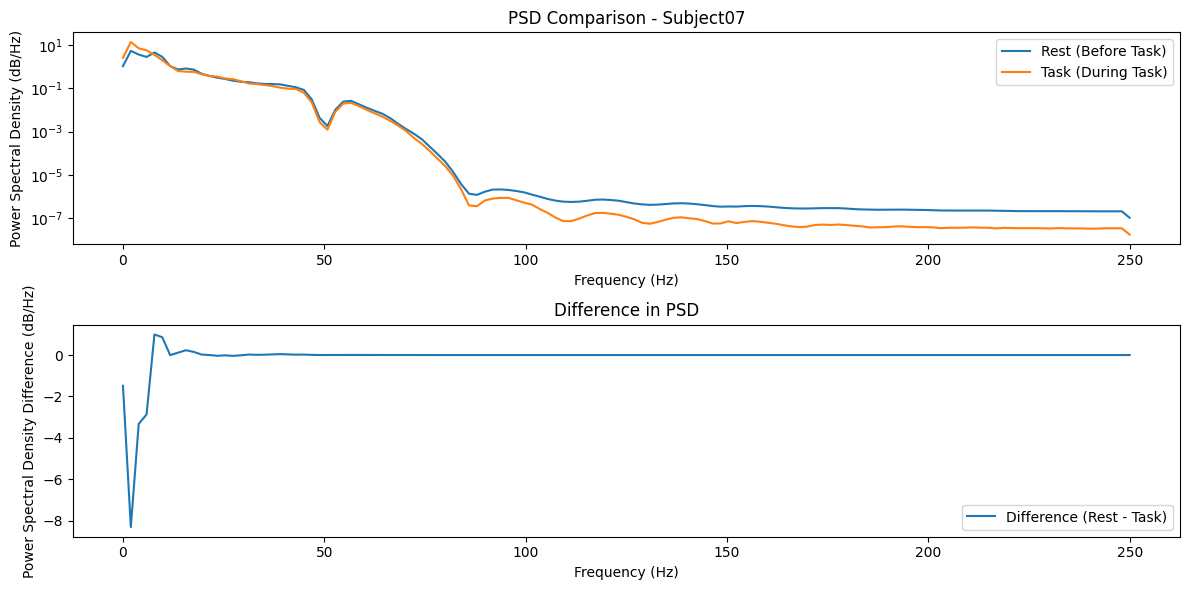

Subject07: Avg Power Before = 0.2047791952378019, Avg Power During = 0.30937855683477294


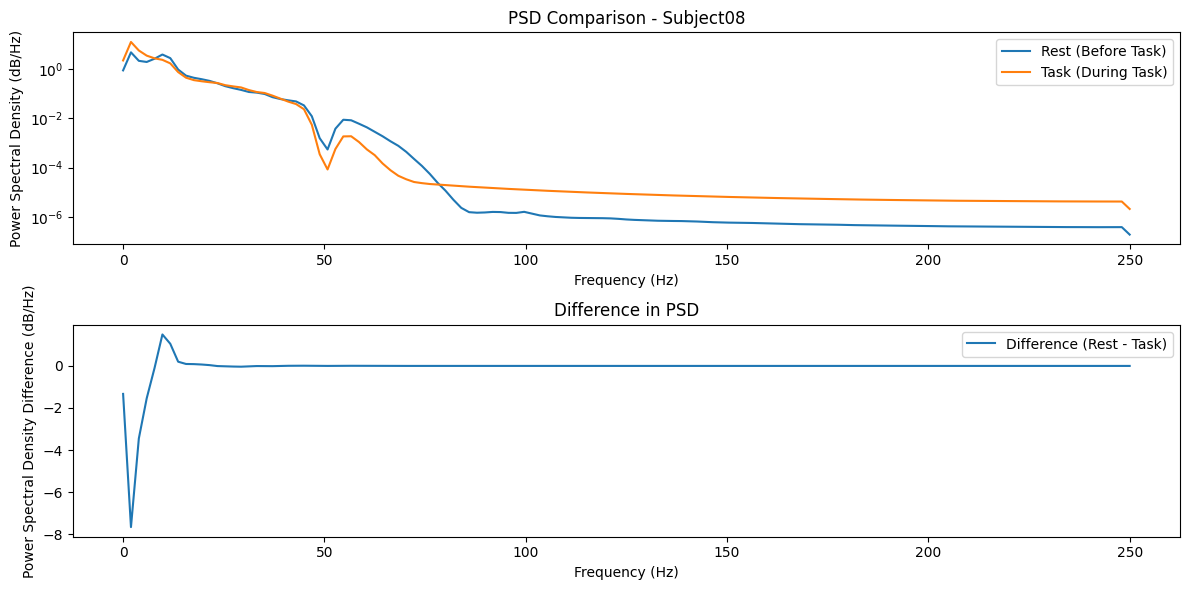

Subject08: Avg Power Before = 0.17638694952413717, Avg Power During = 0.26263465153414667


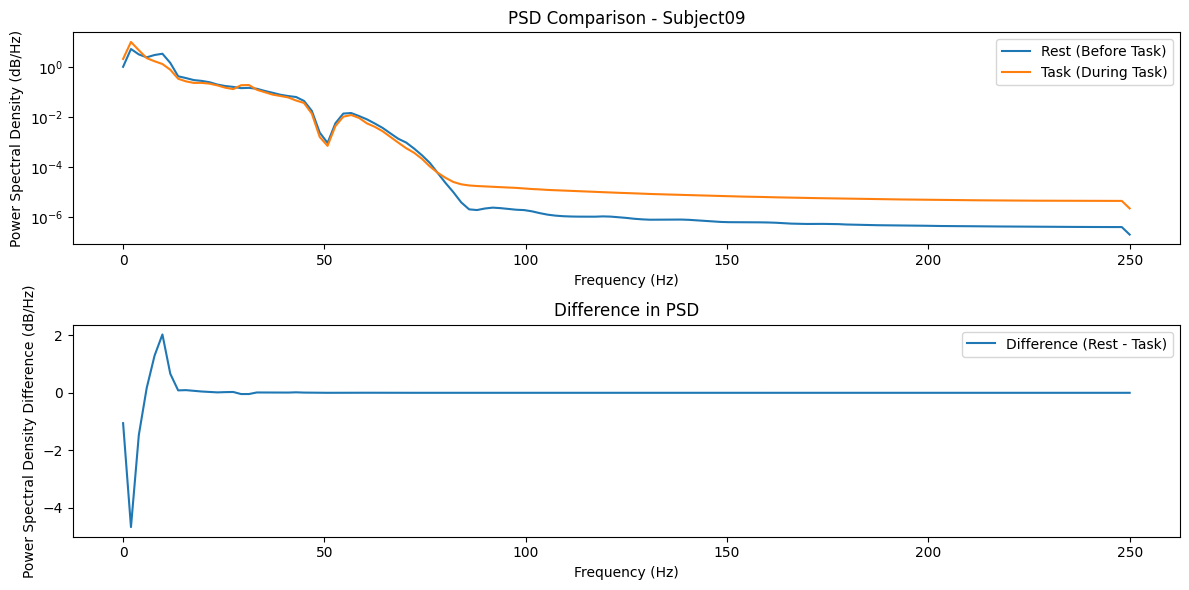

Subject09: Avg Power Before = 0.1734358719940623, Avg Power During = 0.19394640279664313


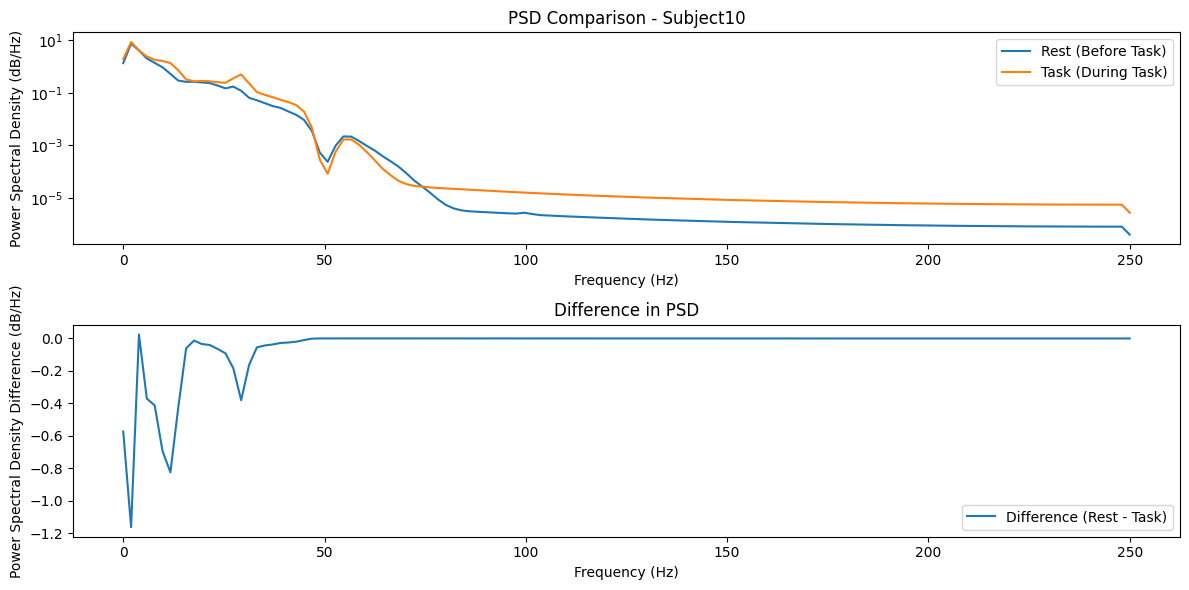

Subject10: Avg Power Before = 0.15399480349597156, Avg Power During = 0.1980650752939338


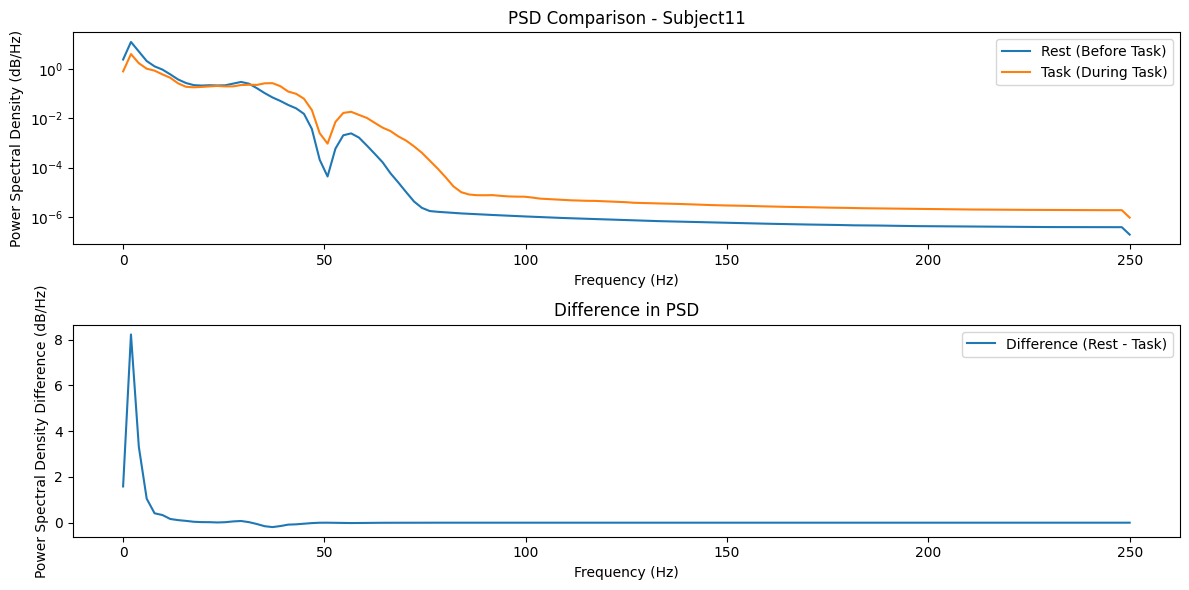

Subject11: Avg Power Before = 0.2118649076169394, Avg Power During = 0.09792034824564985


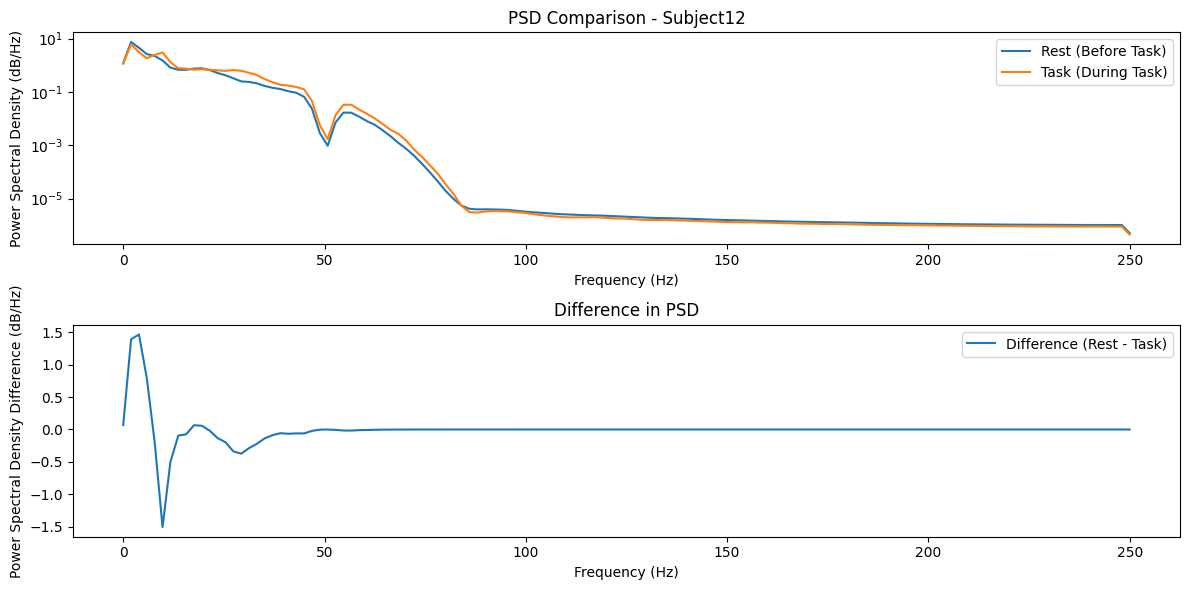

Subject12: Avg Power Before = 0.20834420271097195, Avg Power During = 0.21346372704835817


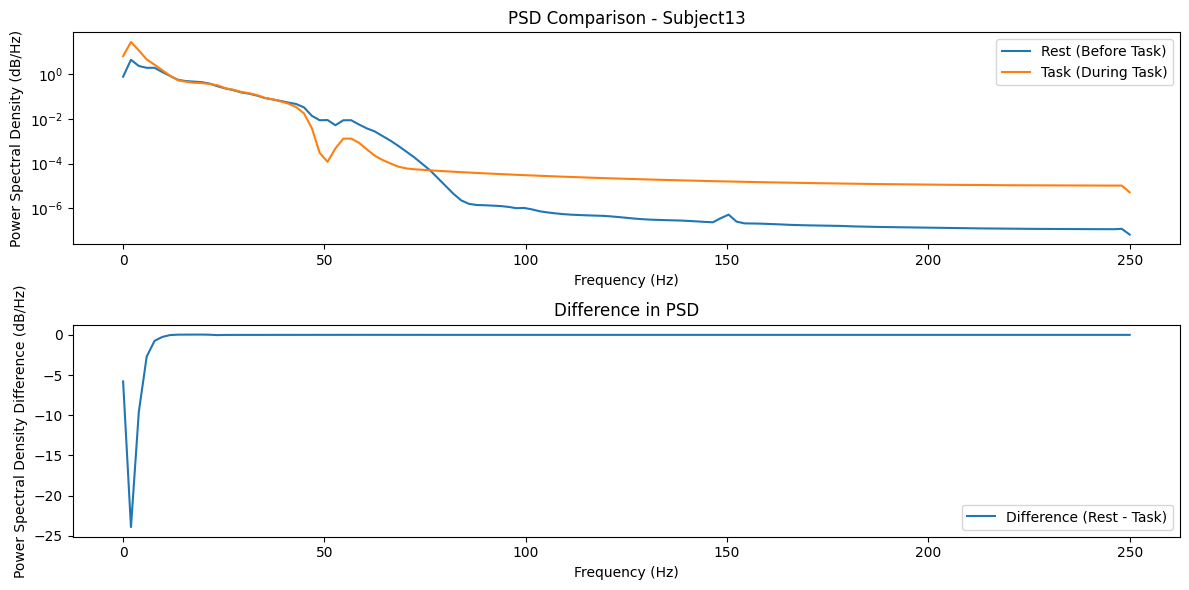

Subject13: Avg Power Before = 0.13738428561184415, Avg Power During = 0.4691605057871732


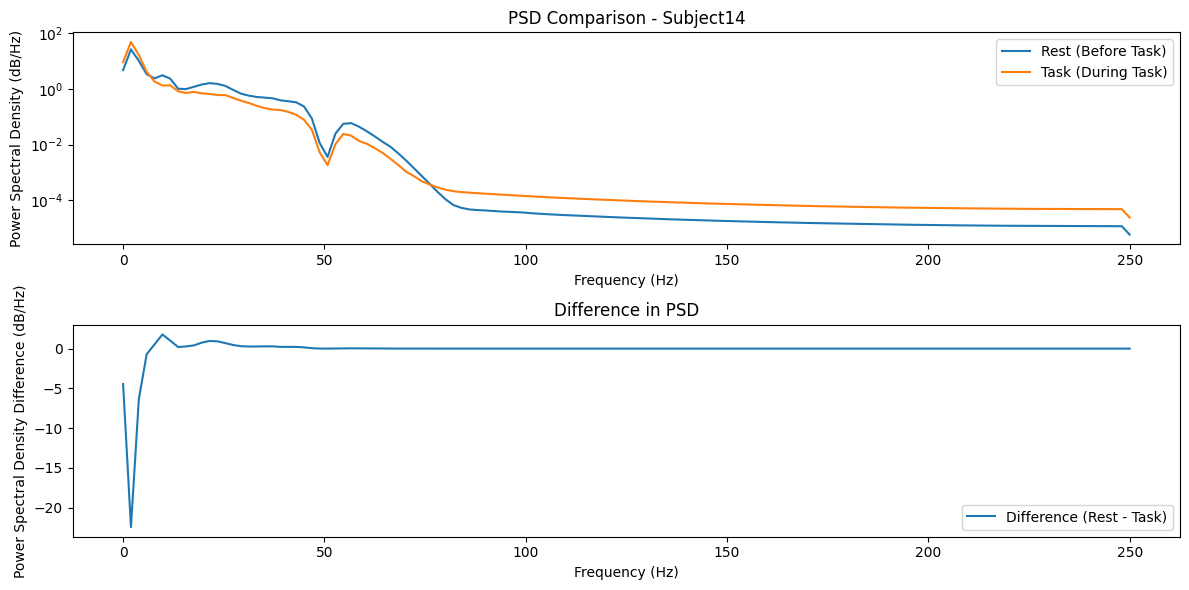

Subject14: Avg Power Before = 0.5212540064441579, Avg Power During = 0.7039055893611031


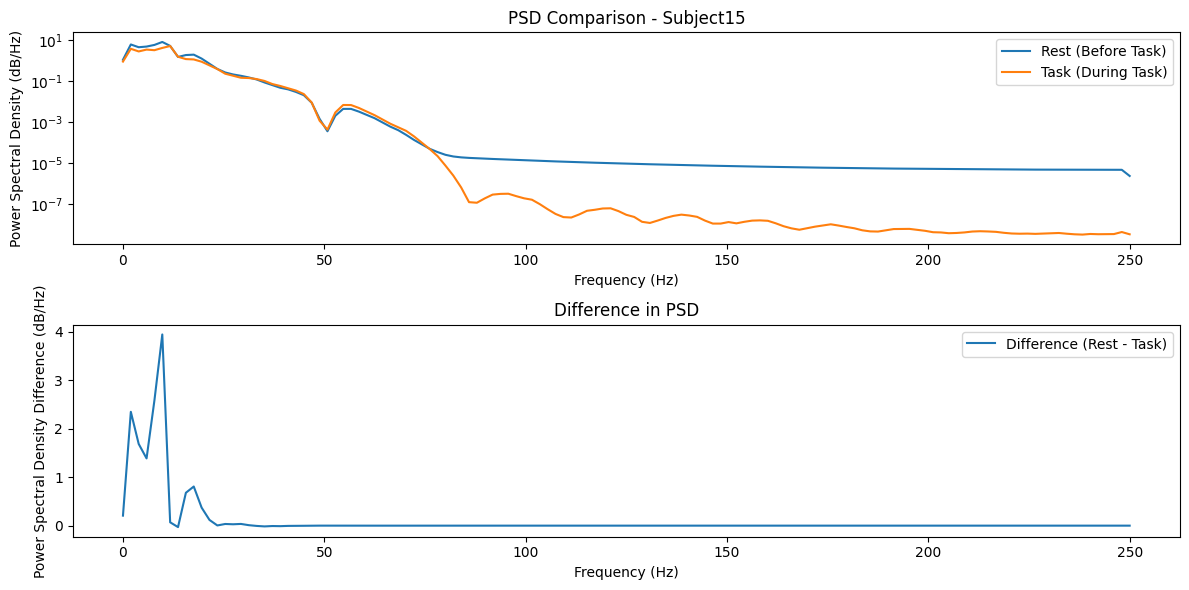

Subject15: Avg Power Before = 0.3447045786622016, Avg Power During = 0.23433651509021436


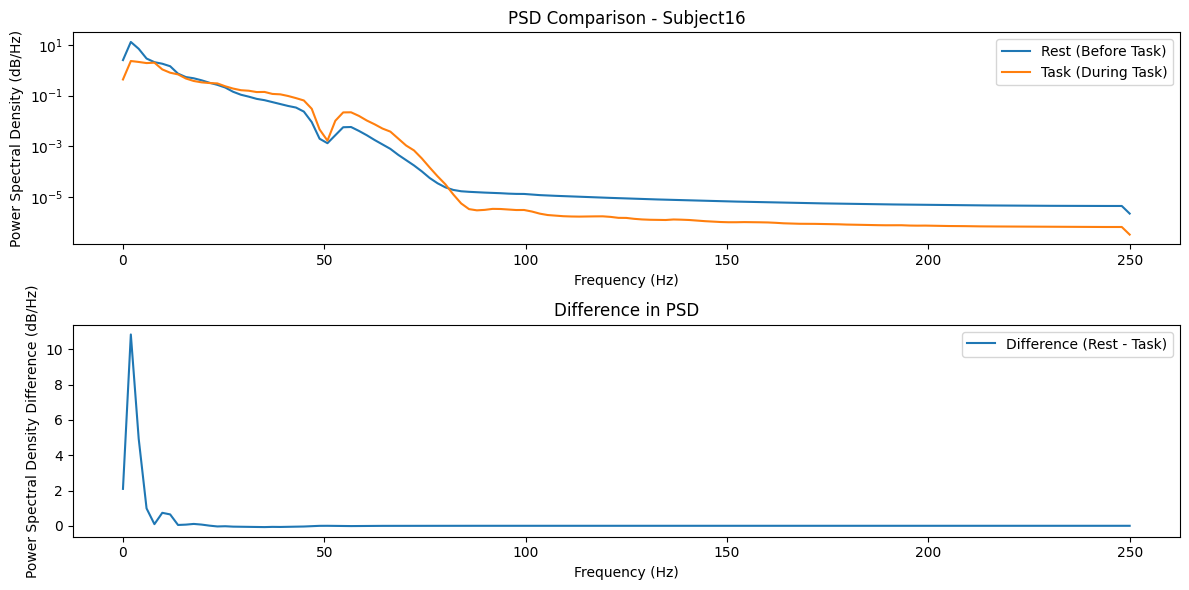

Subject16: Avg Power Before = 0.269211511052265, Avg Power During = 0.11492219545759663


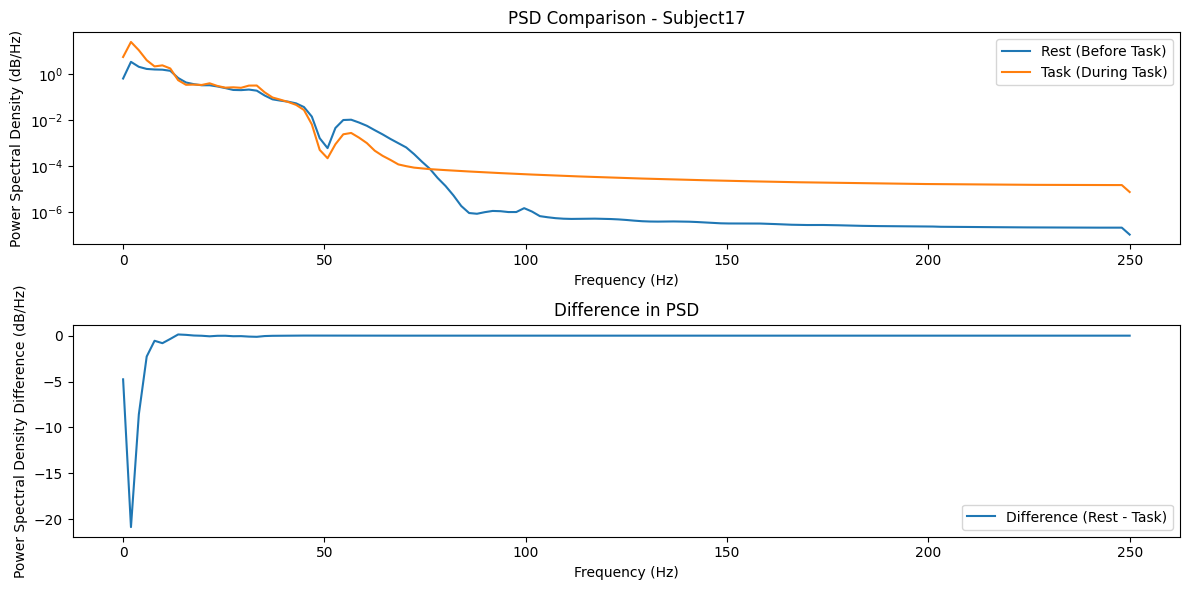

Subject17: Avg Power Before = 0.12315222204446159, Avg Power During = 0.4209385456310538


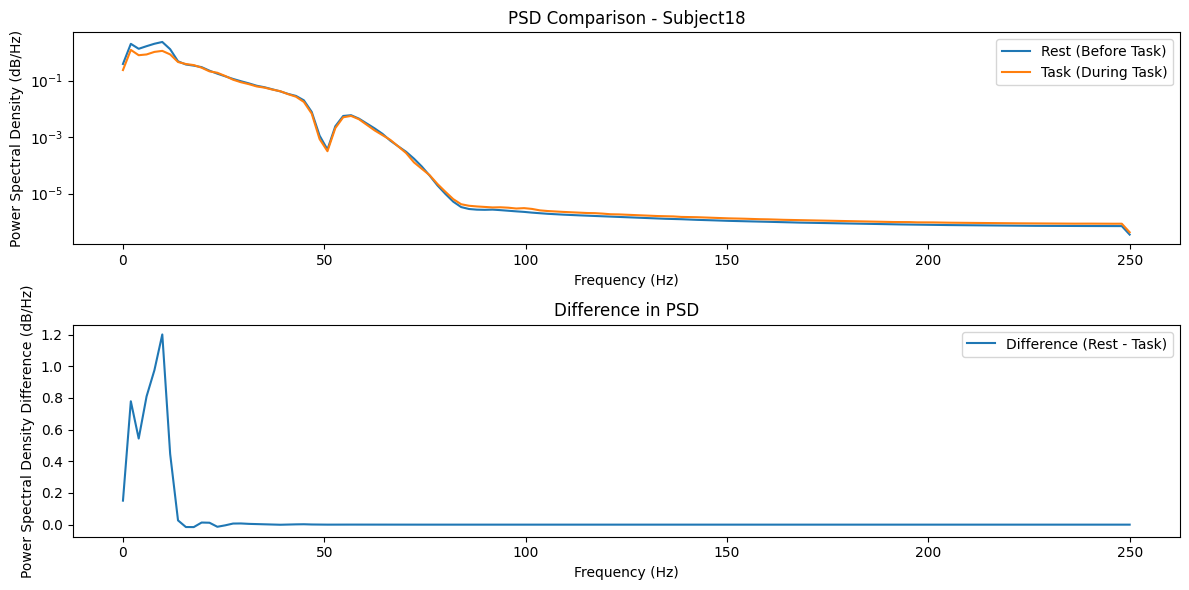

Subject18: Avg Power Before = 0.10575181610349675, Avg Power During = 0.06741897219775748


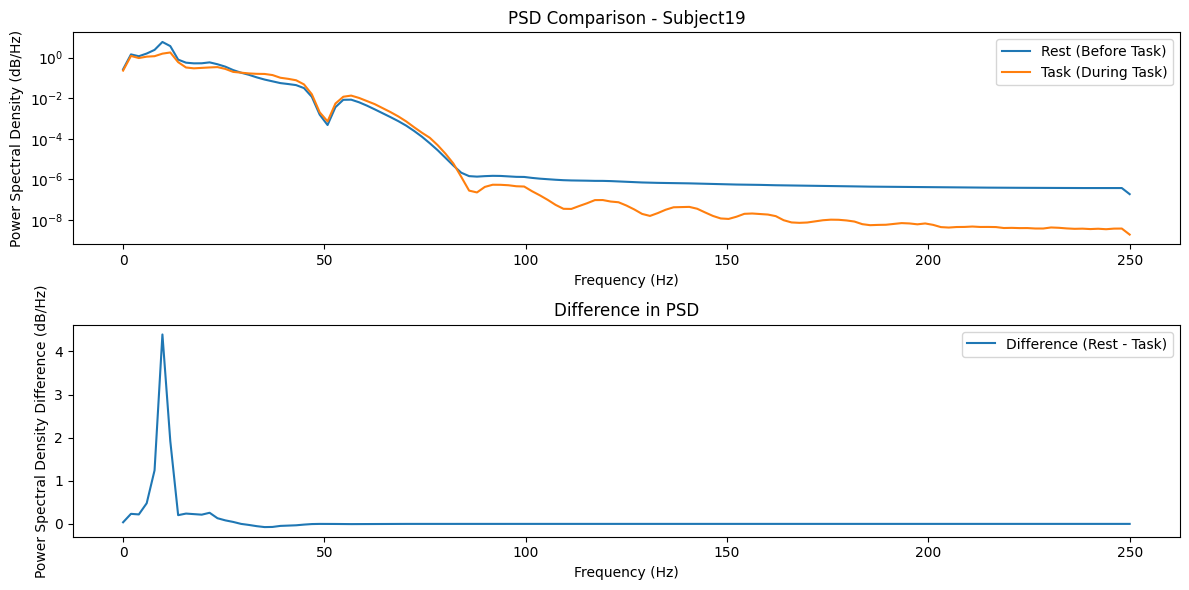

Subject19: Avg Power Before = 0.16707864963899677, Avg Power During = 0.09314231894072866


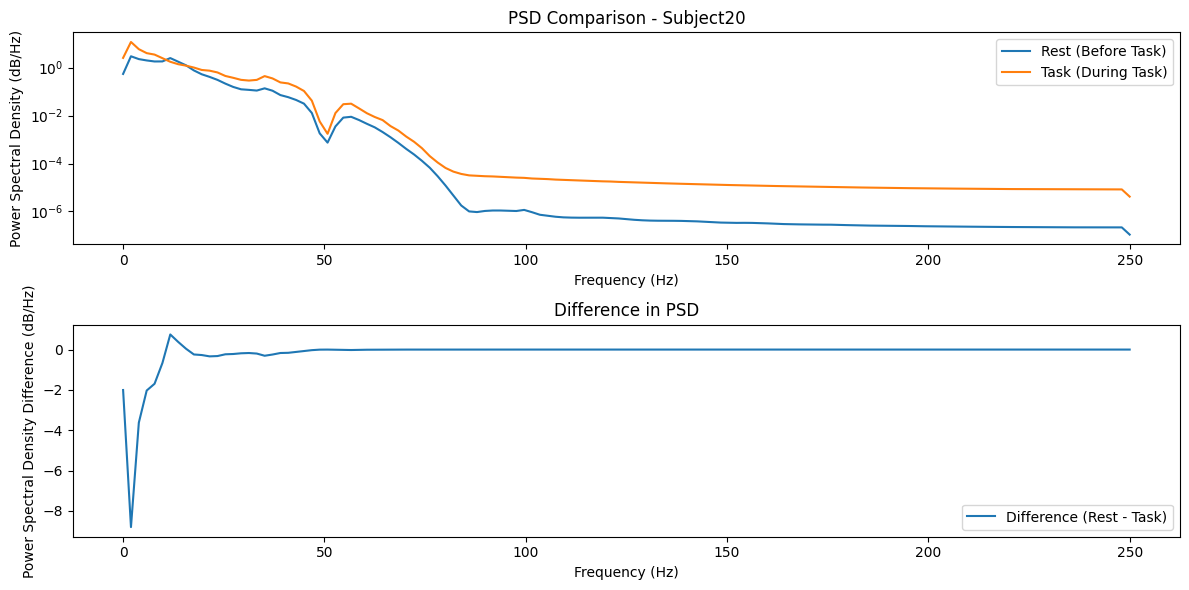

Subject20: Avg Power Before = 0.15656517801713005, Avg Power During = 0.319613705050111


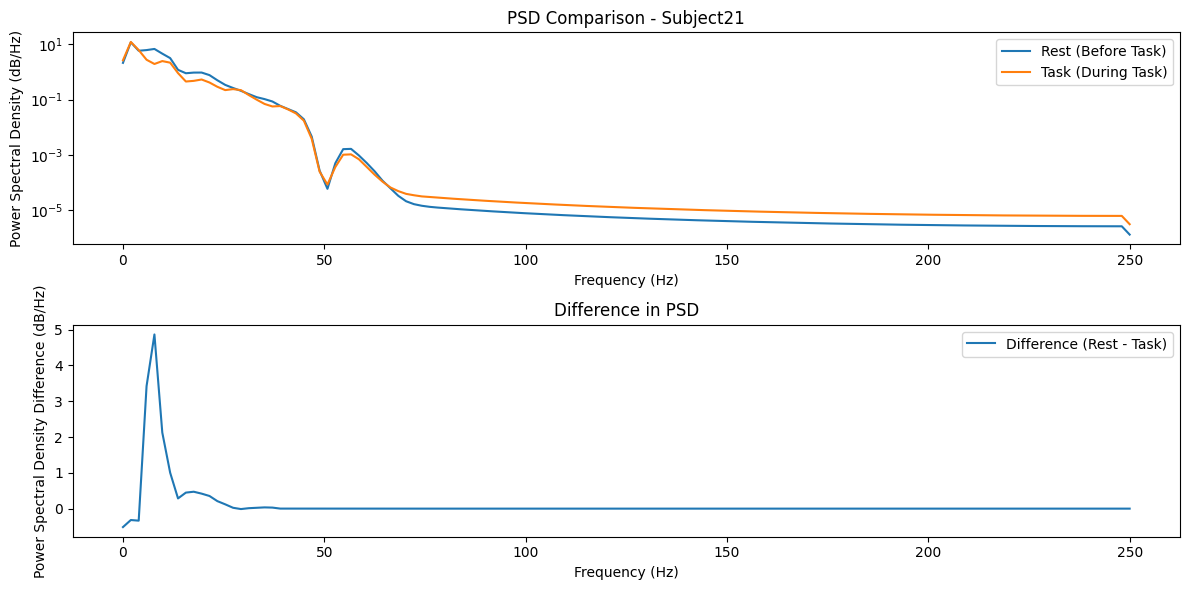

Subject21: Avg Power Before = 0.3669708407243194, Avg Power During = 0.2687319674453506


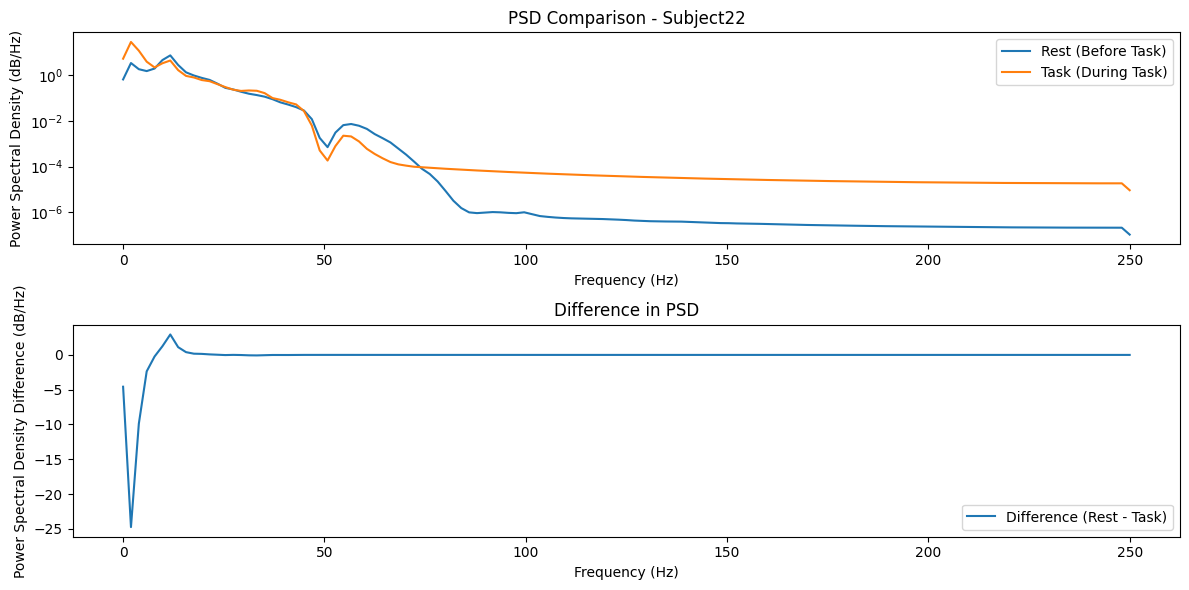

Subject22: Avg Power Before = 0.2277149511205811, Avg Power During = 0.5061970390202727


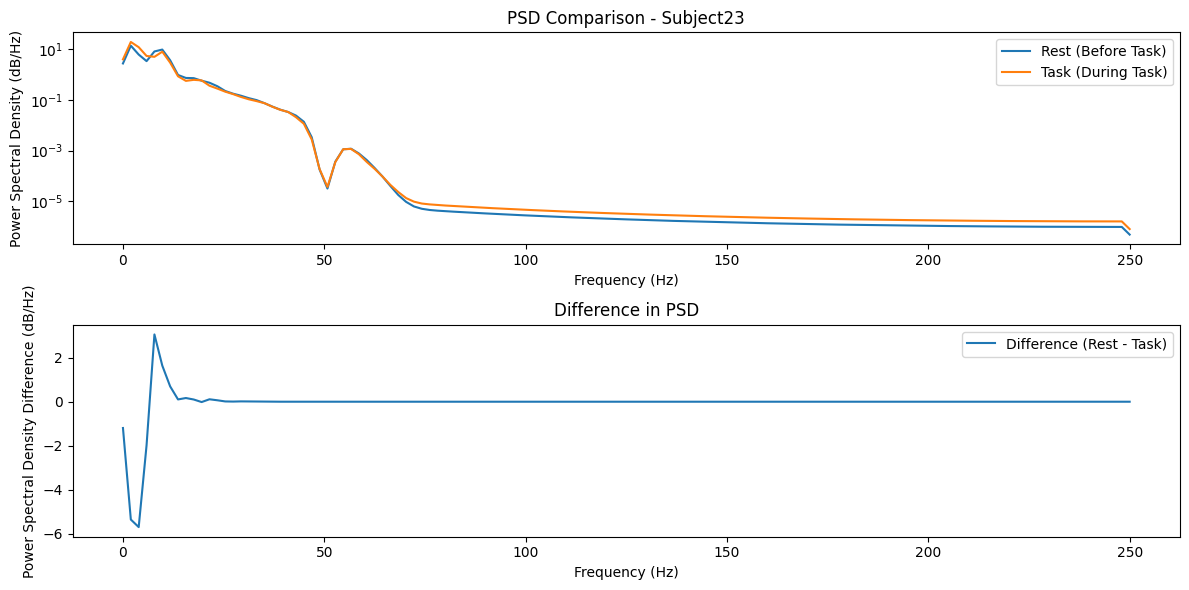

Subject23: Avg Power Before = 0.39559193672830806, Avg Power During = 0.45946558624300793


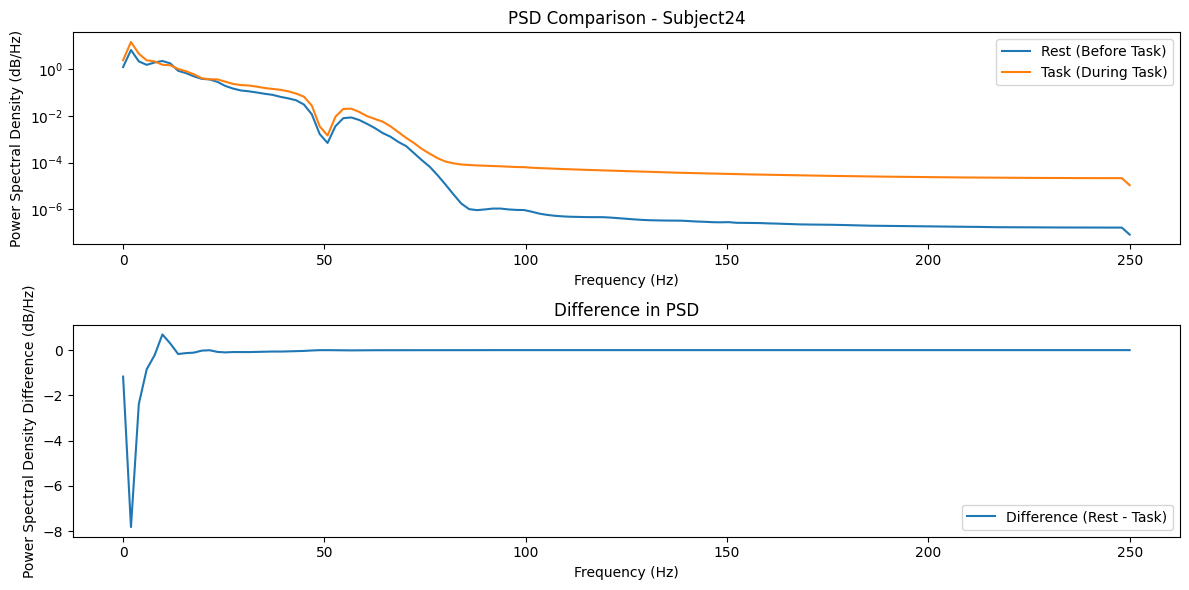

Subject24: Avg Power Before = 0.16460139359253265, Avg Power During = 0.2640471641584814


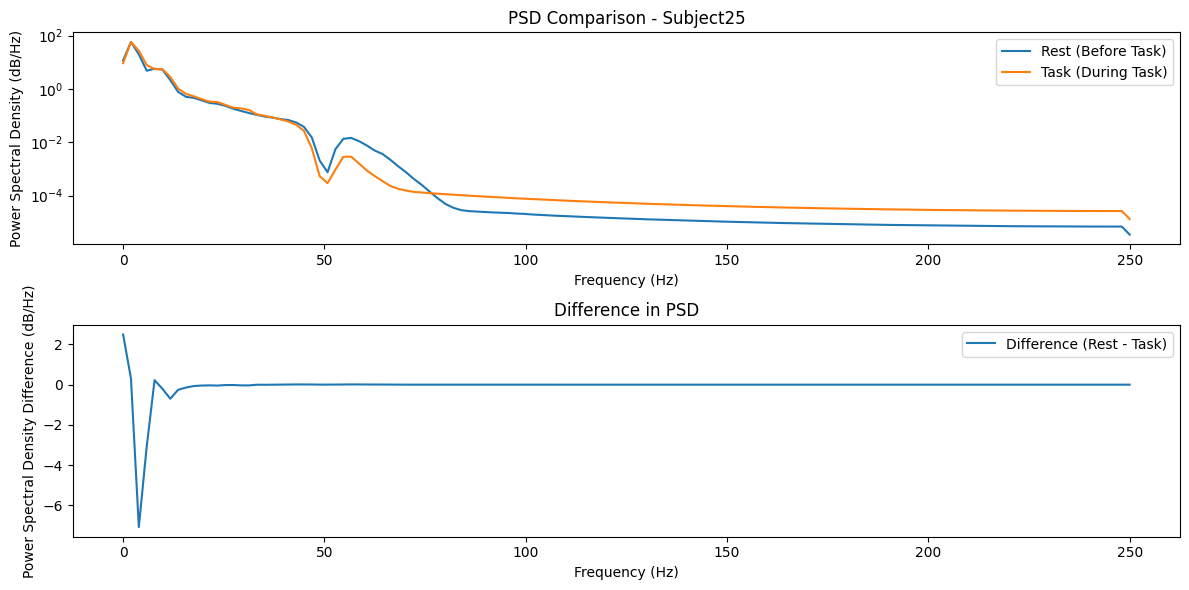

Subject25: Avg Power Before = 0.868771215750345, Avg Power During = 0.9359180315893455


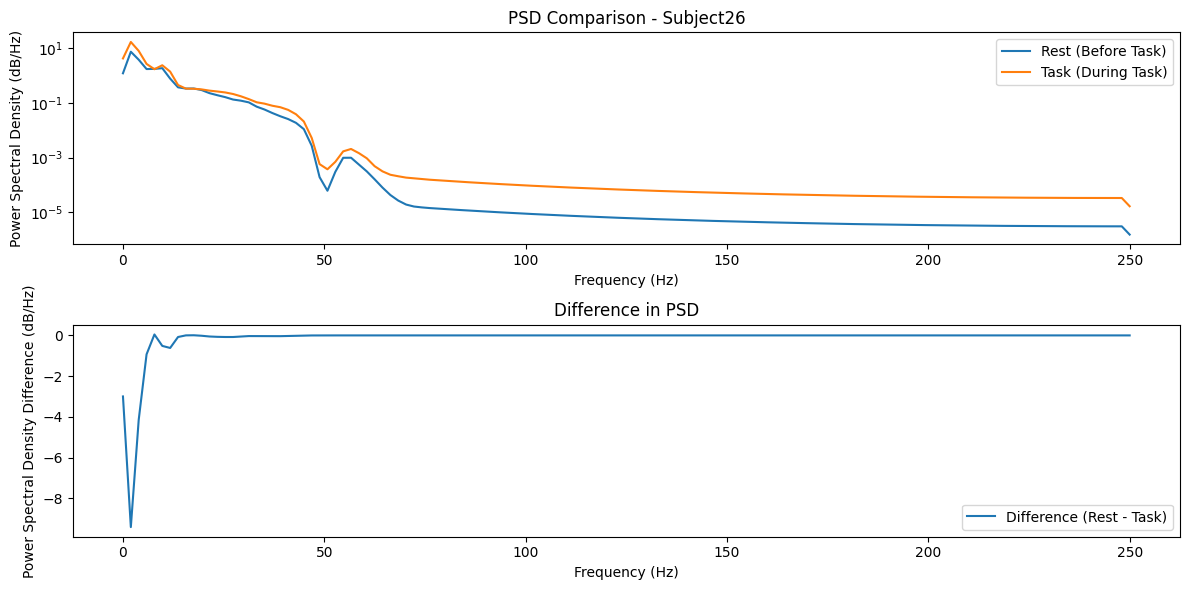

Subject26: Avg Power Before = 0.16278151726071524, Avg Power During = 0.31201485332533974


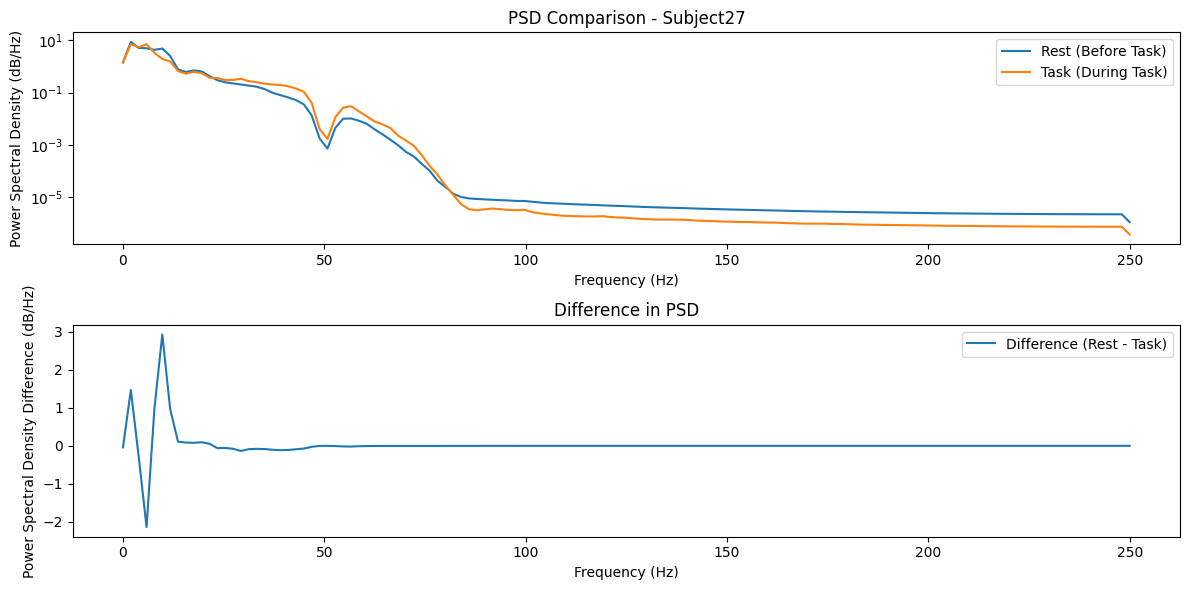

Subject27: Avg Power Before = 0.28483905434383927, Avg Power During = 0.2606324466544014


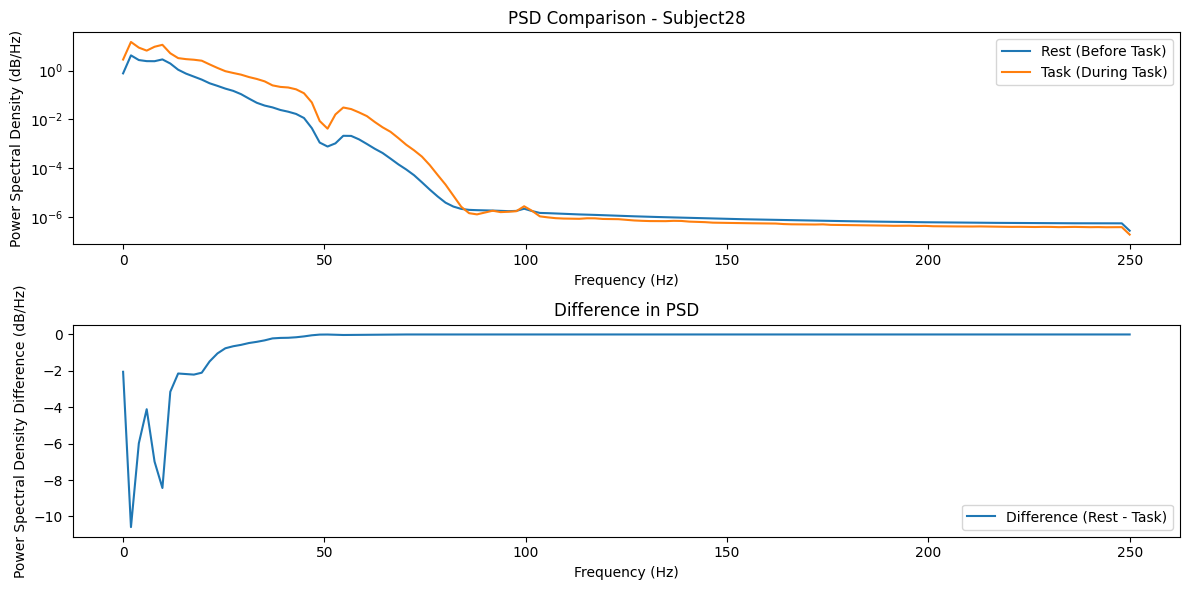

Subject28: Avg Power Before = 0.16536679991722728, Avg Power During = 0.6046230347859805


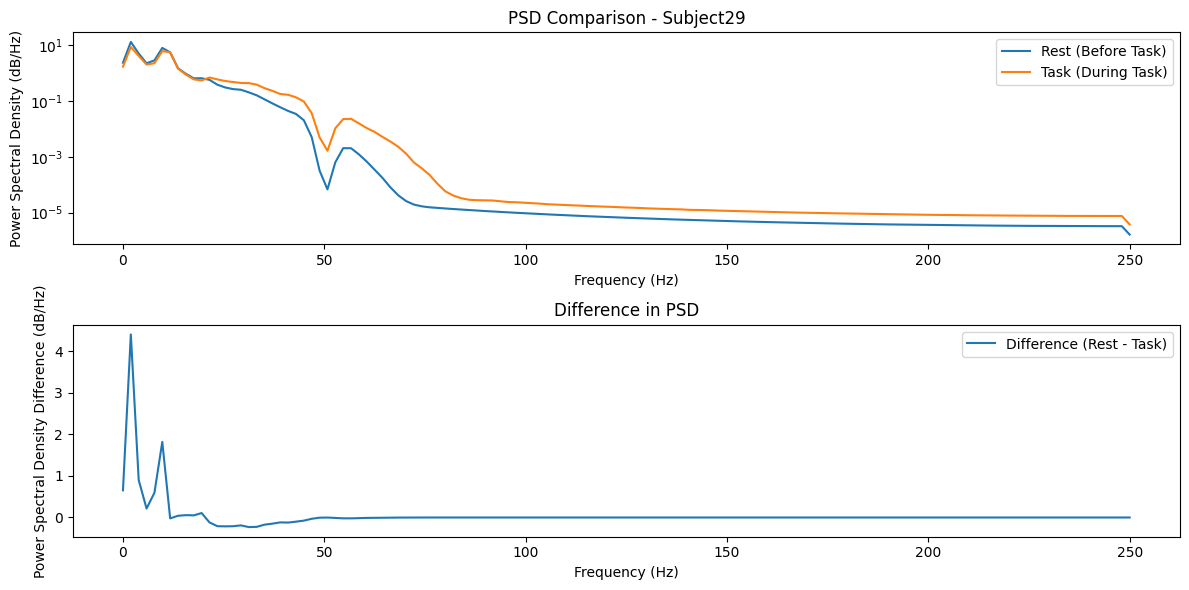

Subject29: Avg Power Before = 0.3498981909132667, Avg Power During = 0.29906528013140005


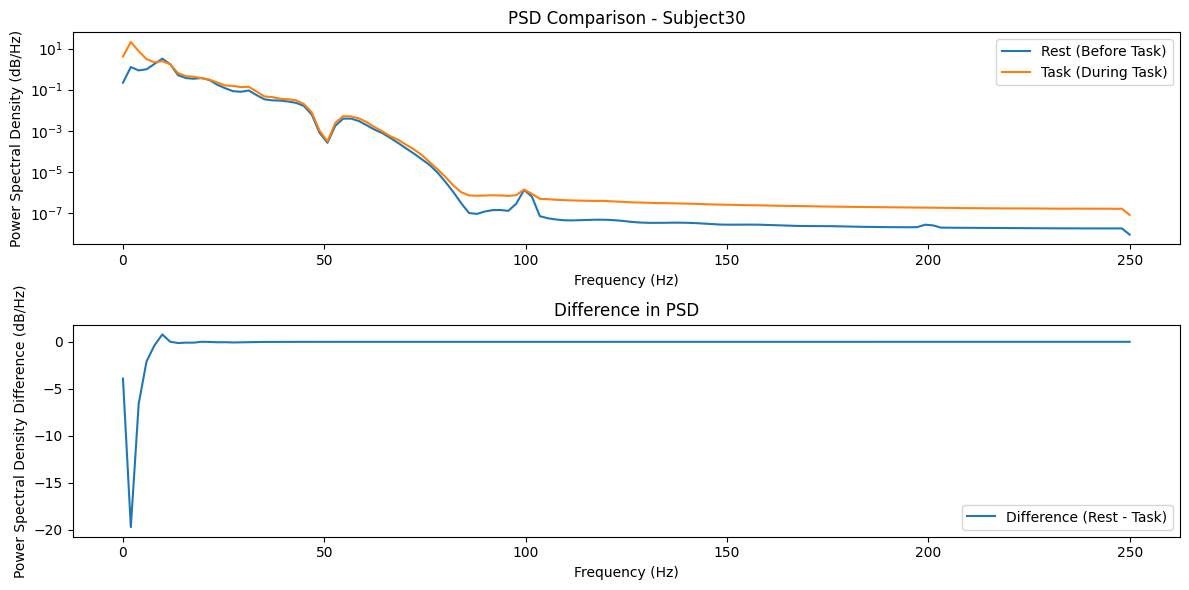

Subject30: Avg Power Before = 0.09878295233941817, Avg Power During = 0.3514407062390645


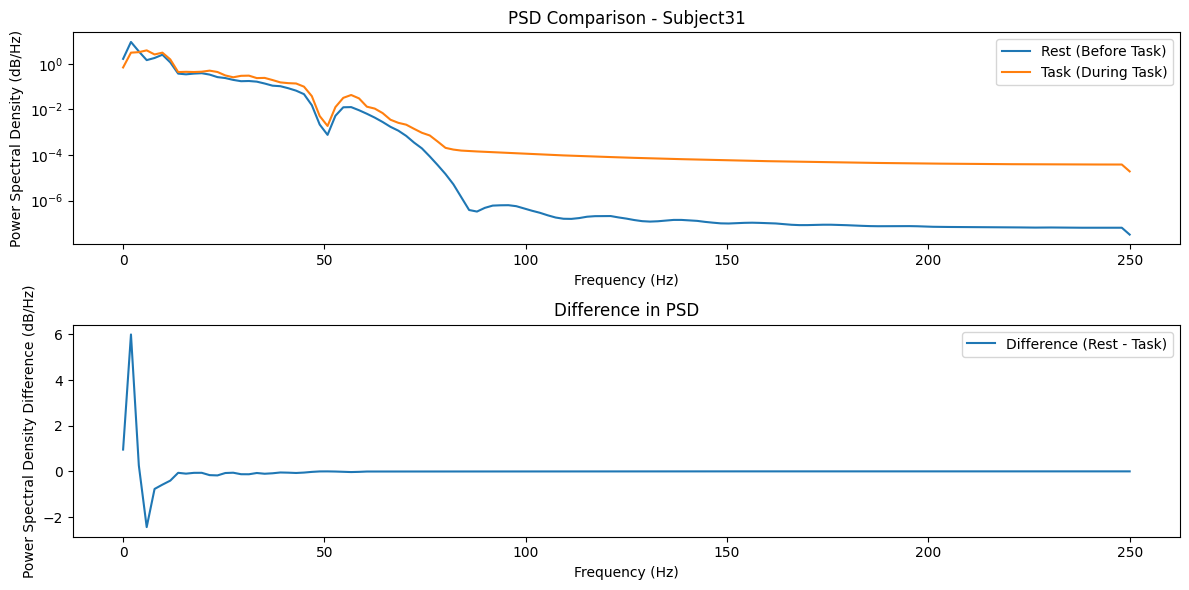

Subject31: Avg Power Before = 0.19223252335174656, Avg Power During = 0.1815867392767555


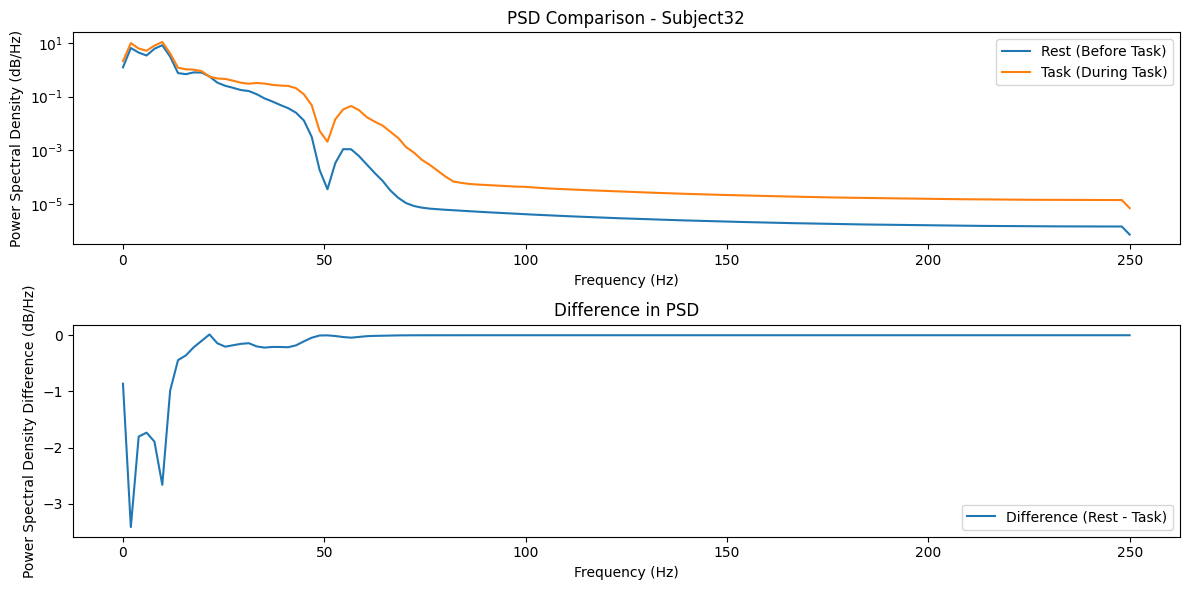

Subject32: Avg Power Before = 0.29551425558268646, Avg Power During = 0.4261452266760732


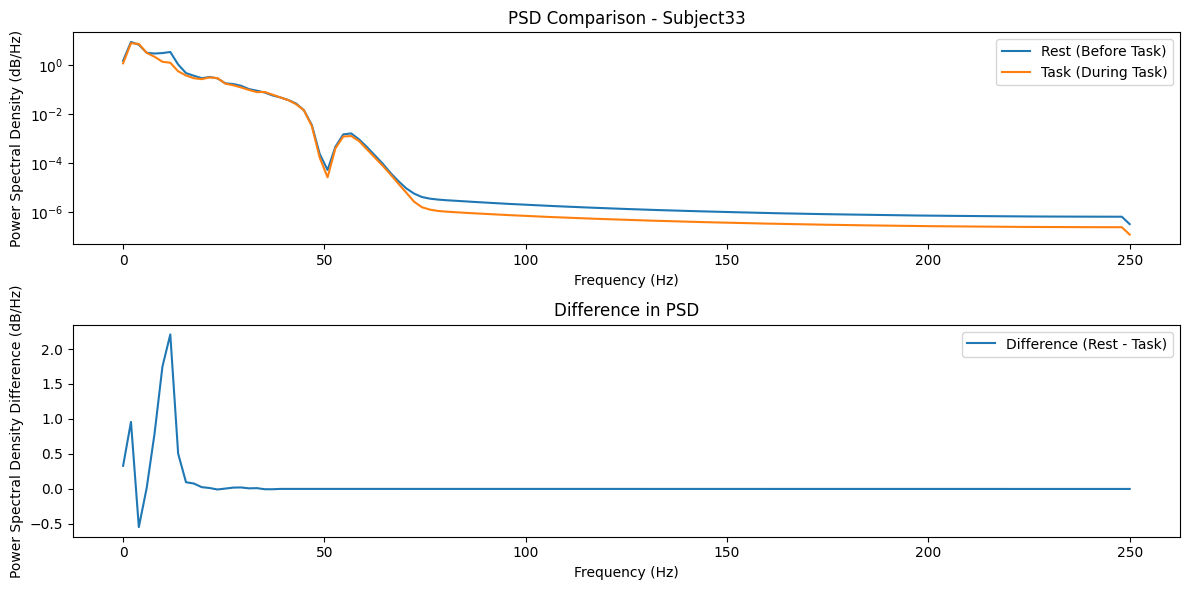

Subject33: Avg Power Before = 0.26312800509216955, Avg Power During = 0.21448422500330708


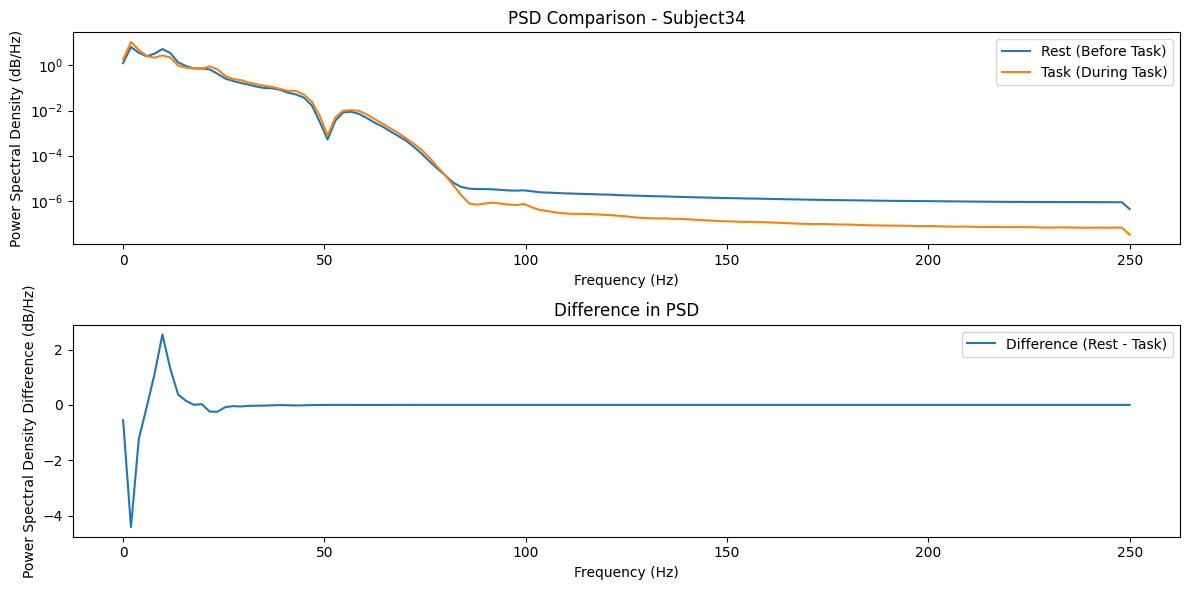

Subject34: Avg Power Before = 0.2516196678904767, Avg Power During = 0.2641476290484422


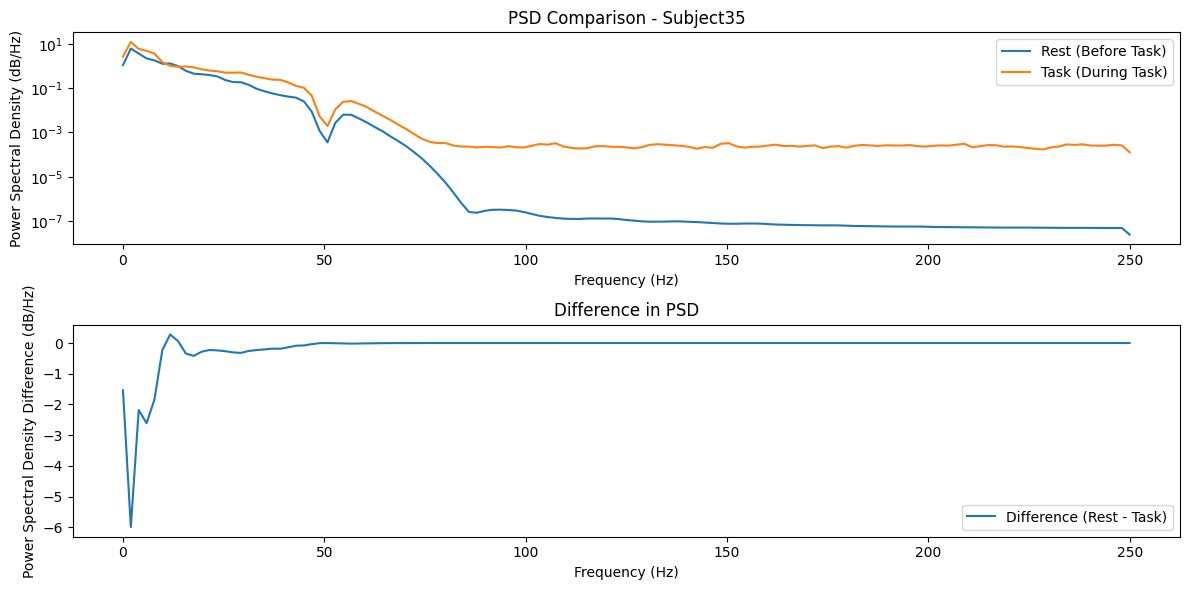

Subject35: Avg Power Before = 0.16714798237068643, Avg Power During = 0.3066060251929264


In [6]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Function to compute PSD for an EDF file
def compute_psd(edf_file):
    try:
        # Opening the EDF file
        f = pyedflib.EdfReader(edf_file)

        # Getting number of signals (channels)
        n_signals = f.signals_in_file

        # Assume EEG is in the first channel (adjust if necessary)
        signal = f.readSignal(0)
        fs = f.getSampleFrequency(0)

        # Close the file
        f.close()

        # Compute PSD using Welch's method
        frequencies, psd = welch(signal, fs=fs, nperseg=256)
        return frequencies, psd

    except Exception as e:
        print(f"Error processing {edf_file}: {e}")
        return None, None

# List of EDF files to process
edf_files = []

# Generate list of files from 'Subject00_1.edf' to 'Subject35_2.edf'
for subject in range(36):  # Subjects 00 to 35
    edf_files.append((
        f'{data_path}/Subject{subject:02}_1.edf',  # Rest state
        f'{data_path}/Subject{subject:02}_2.edf'   # Task state
    ))

# Compute and compare PSDs for each subject
for file_before, file_during in edf_files:
    freqs_before, psd_before = compute_psd(file_before)
    freqs_during, psd_during = compute_psd(file_during)

    if freqs_before is not None and freqs_during is not None:
        # Plot comparison of PSDs
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 1, 1)
        plt.semilogy(freqs_before, psd_before, label='Rest (Before Task)')
        plt.semilogy(freqs_during, psd_during, label='Task (During Task)')
        plt.title(f'PSD Comparison - {file_before.split("/")[-1][:9]}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(freqs_before, psd_before - psd_during, label='Difference (Rest - Task)')
        plt.title('Difference in PSD')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density Difference (dB/Hz)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Summarize findings (example summary based on visual inspection)
        avg_power_before = np.mean(psd_before)
        avg_power_during = np.mean(psd_during)
        print(f'{file_before.split("/")[-1][:9]}: Avg Power Before = {avg_power_before}, Avg Power During = {avg_power_during}')


#Observations
#1. A common trend observed by doing PSD Analysis on the provided EEG data is that there is a general increase in delta power across most subjects compared to rest state.
#2.Additionally, bands namely Theta, Alpha, Beta and Gamma did not show consistent changes across subjects, from which I came to a conclusion that delta is more prominent indicator.

#3a. Extract relevant features from the cleaned data

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...   

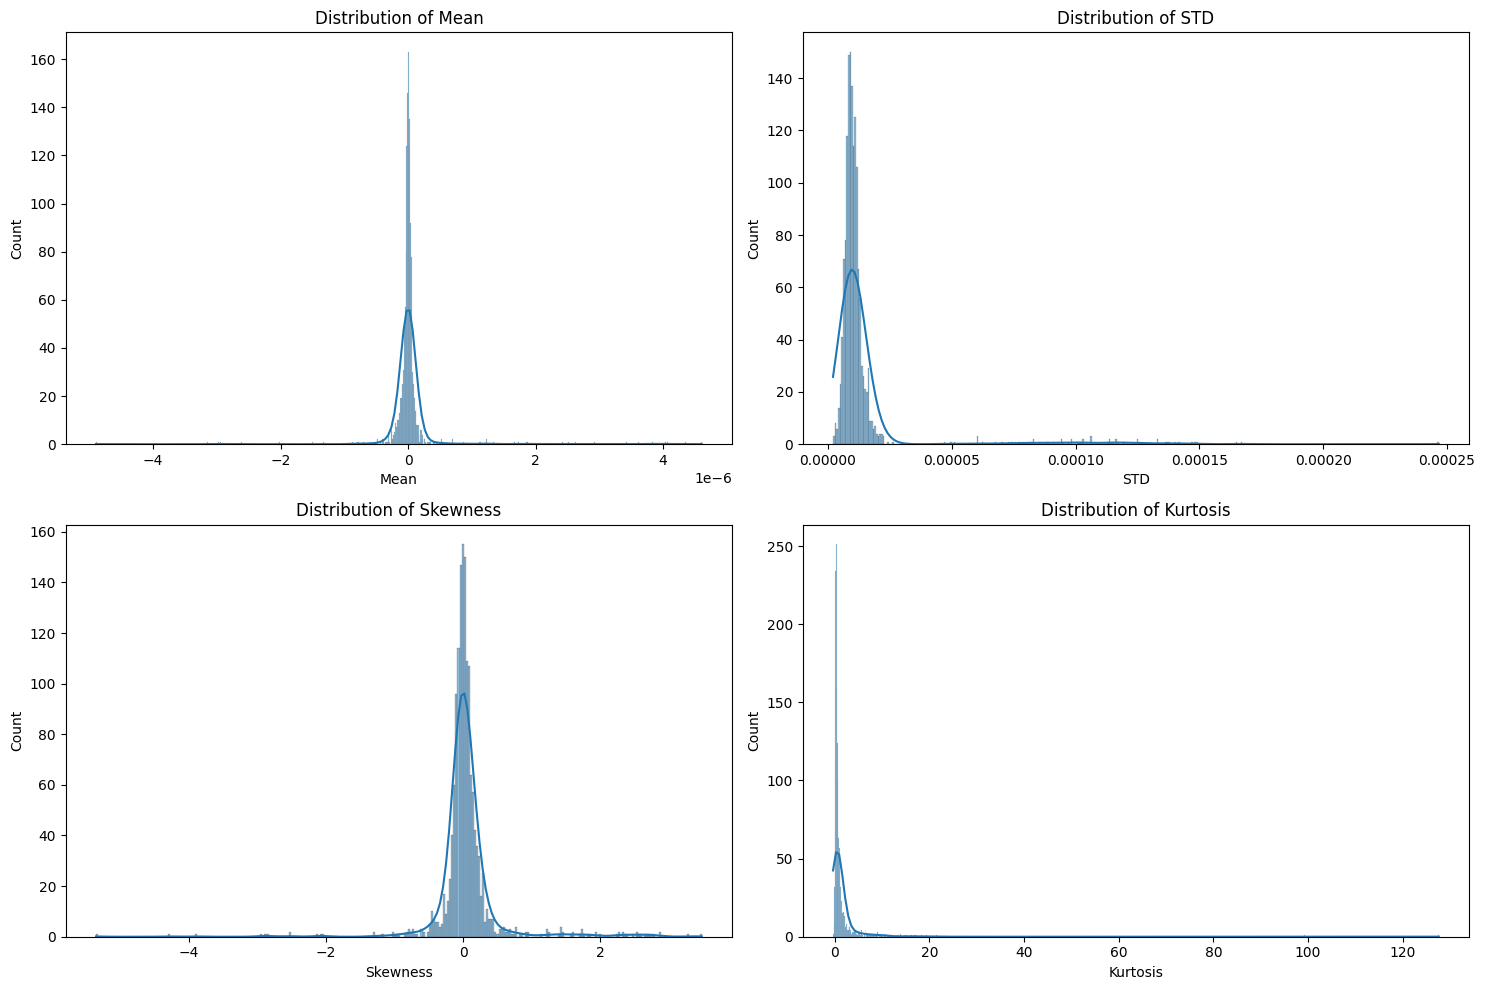

In [7]:
import os
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Define the path to the dataset on Google Drive
data_path = '/content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0'

# Initialize lists to store features
mean_signal = []
std_signal = []
skew_signal = []
kurt_signal = []

# Function to extract time-domain features
def extract_time_domain_features(signal):
    mean_val = np.mean(signal, axis=1)
    std_val = np.std(signal, axis=1)
    skew_val = skew(signal, axis=1)
    kurt_val = kurtosis(signal, axis=1)
    return mean_val, std_val, skew_val, kurt_val

# Loop through all the subjects and their respective recordings
for subject in range(36):  # Assuming subjects are numbered from 00 to 35
    for state in ['_1.edf', '_2.edf']:  # '_1' for rest state and '_2' for task state
        file_path = os.path.join(data_path, f'Subject{str(subject).zfill(2)}{state}')
        if os.path.exists(file_path):
            # Load the EDF file
            raw = mne.io.read_raw_edf(file_path, preload=True)
            data = raw.get_data()

            # Extract features
            mean_val, std_val, skew_val, kurt_val = extract_time_domain_features(data)
            mean_signal.append(mean_val)
            std_signal.append(std_val)
            skew_signal.append(skew_val)
            kurt_signal.append(kurt_val)

# Convert lists to numpy arrays
mean_signal = np.array(mean_signal)
std_signal = np.array(std_signal)
skew_signal = np.array(skew_signal)
kurt_signal = np.array(kurt_signal)

# Prepare data for visualization
time_domain_features_df = pd.DataFrame({
    'Mean': mean_signal.flatten(),
    'STD': std_signal.flatten(),
    'Skewness': skew_signal.flatten(),
    'Kurtosis': kurt_signal.flatten()
})

# Plot time-domain features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(time_domain_features_df.columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(time_domain_features_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject00_1.edf and Subject00_2.edf: 5


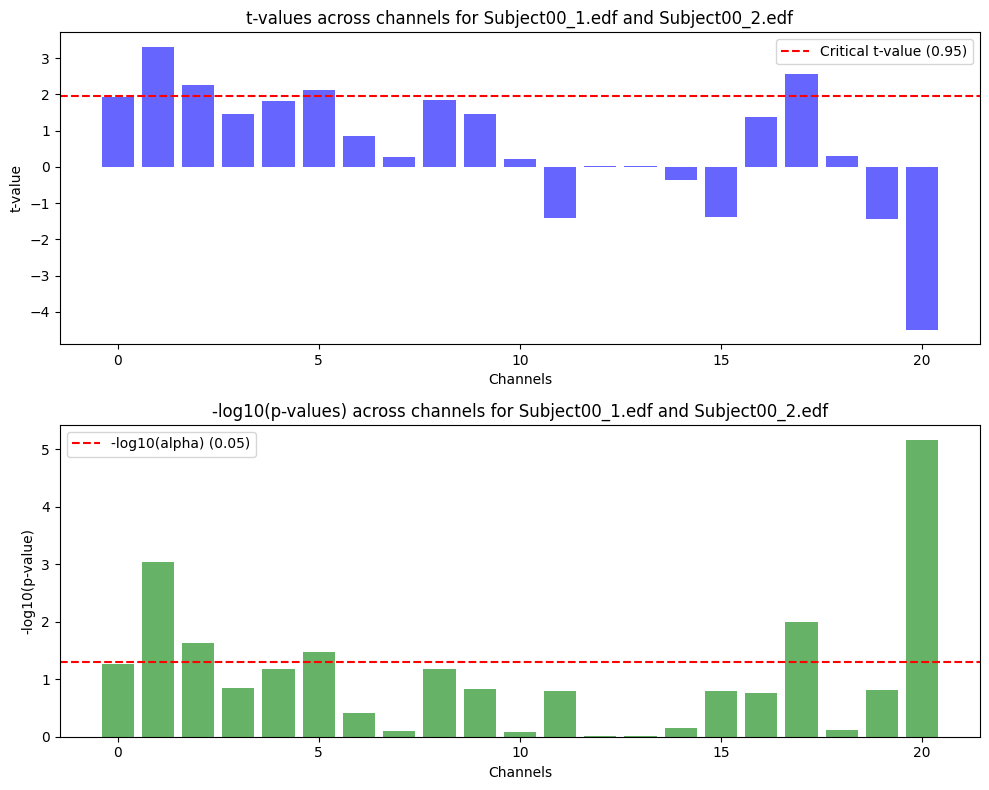

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject01_1.edf and Subject01_2.edf: 7


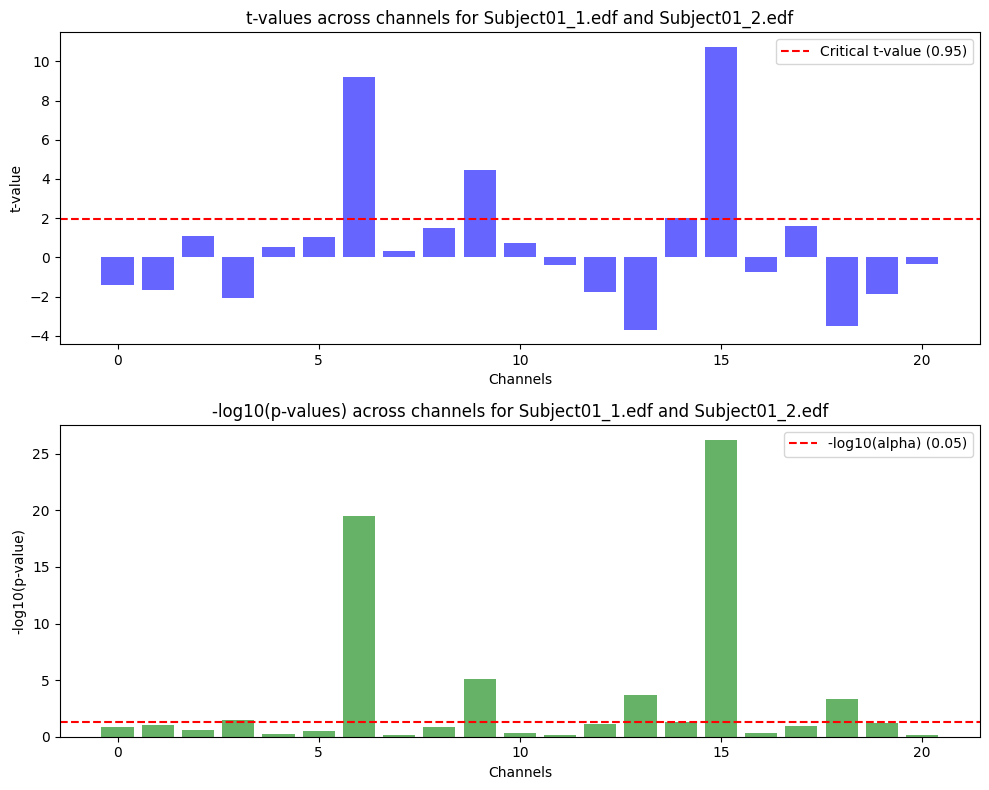

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject02_1.edf and Subject02_2.edf: 2


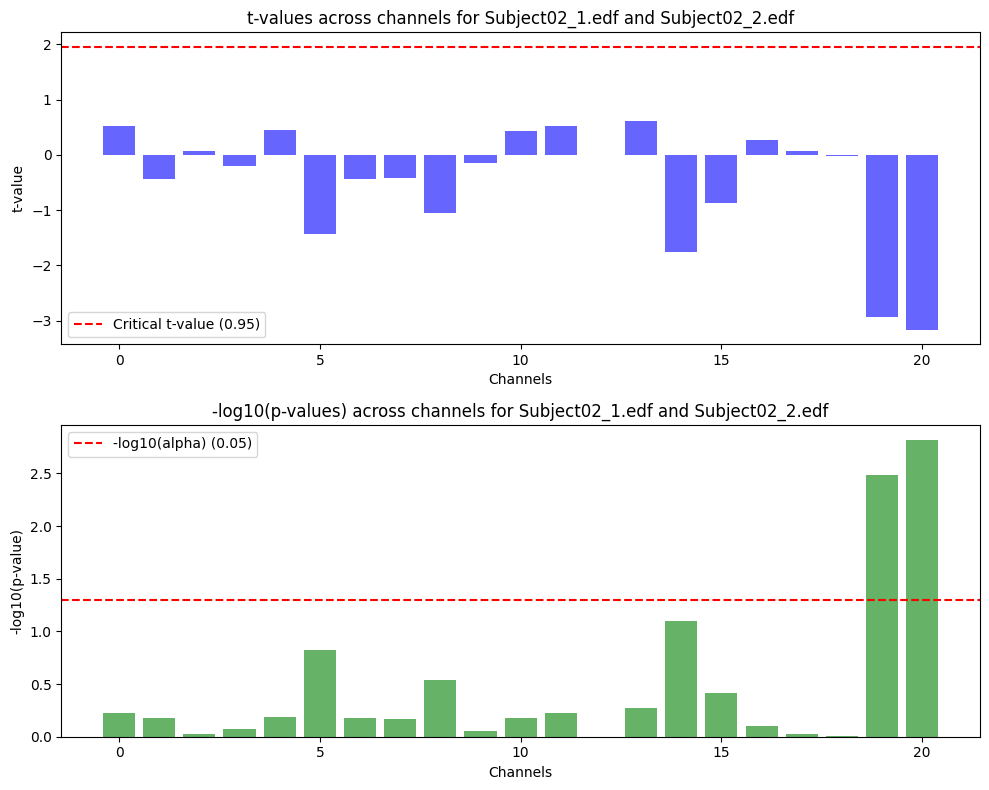

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject03_1.edf and Subject03_2.edf: 1


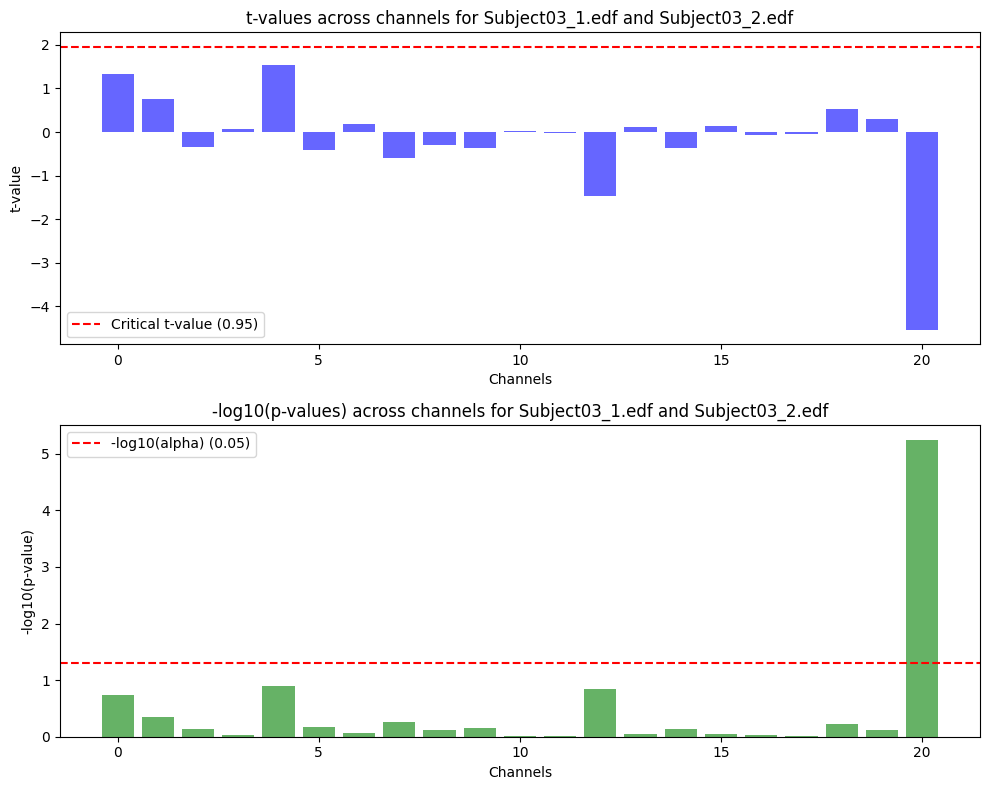

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject04_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 84999  =      0.000 ...   169.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject04_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject04_1.edf and Subject04_2.edf: 1


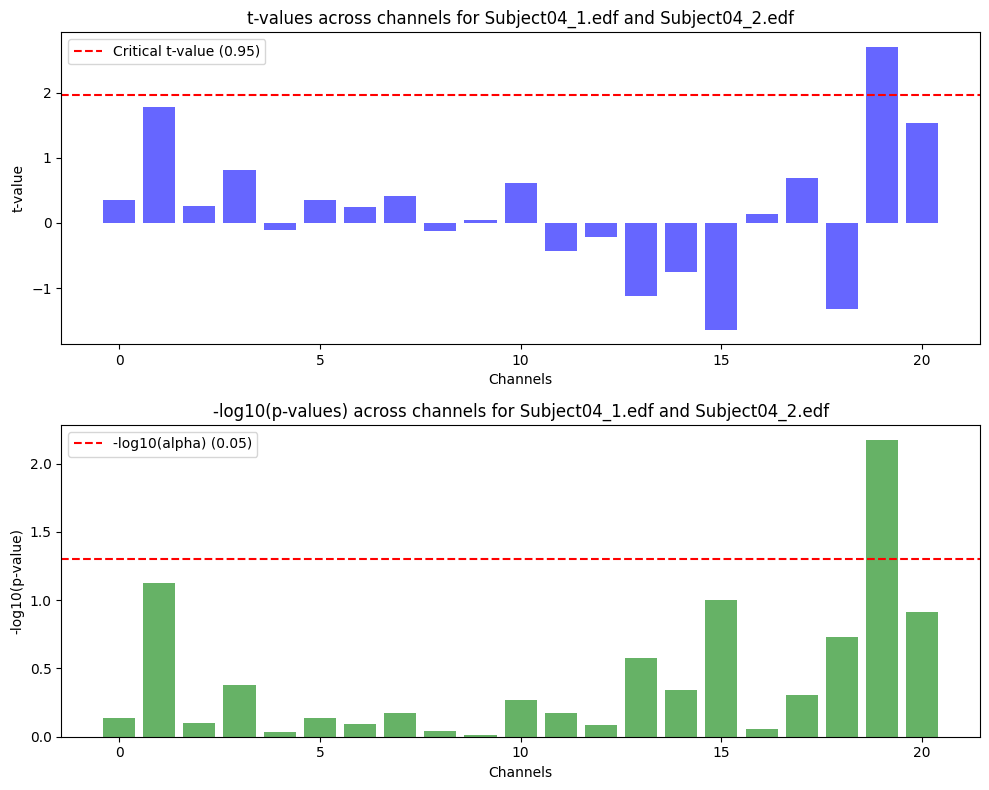

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject05_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject05_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject05_1.edf and Subject05_2.edf: 5


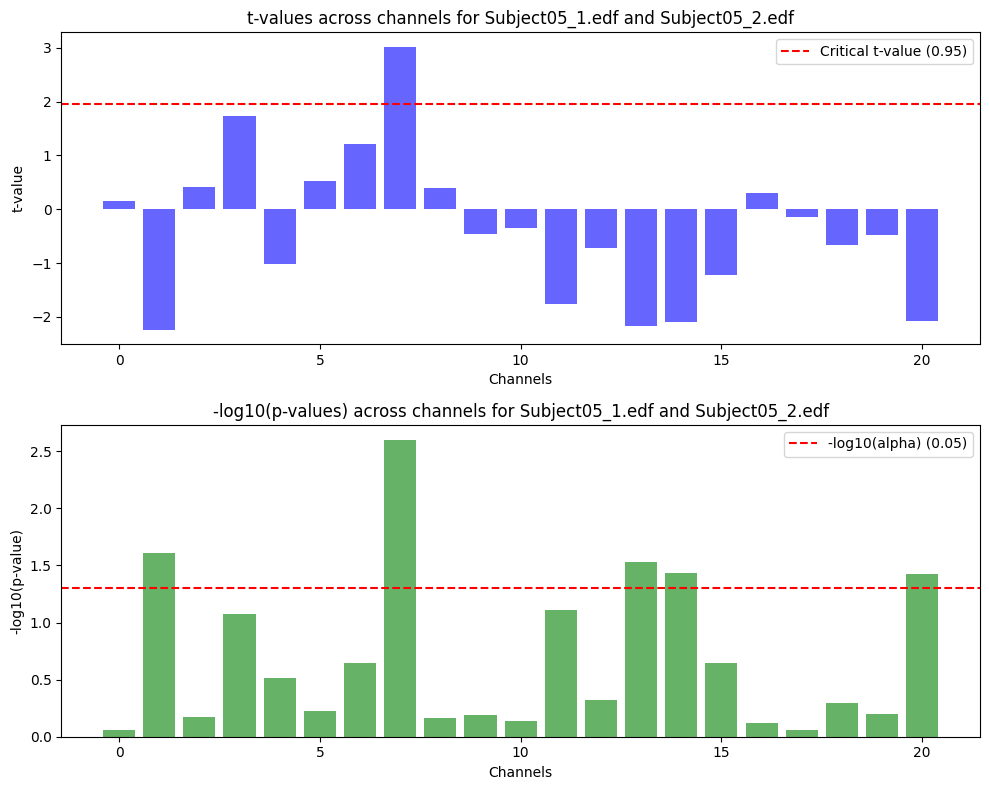

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject06_1.edf and Subject06_2.edf: 1


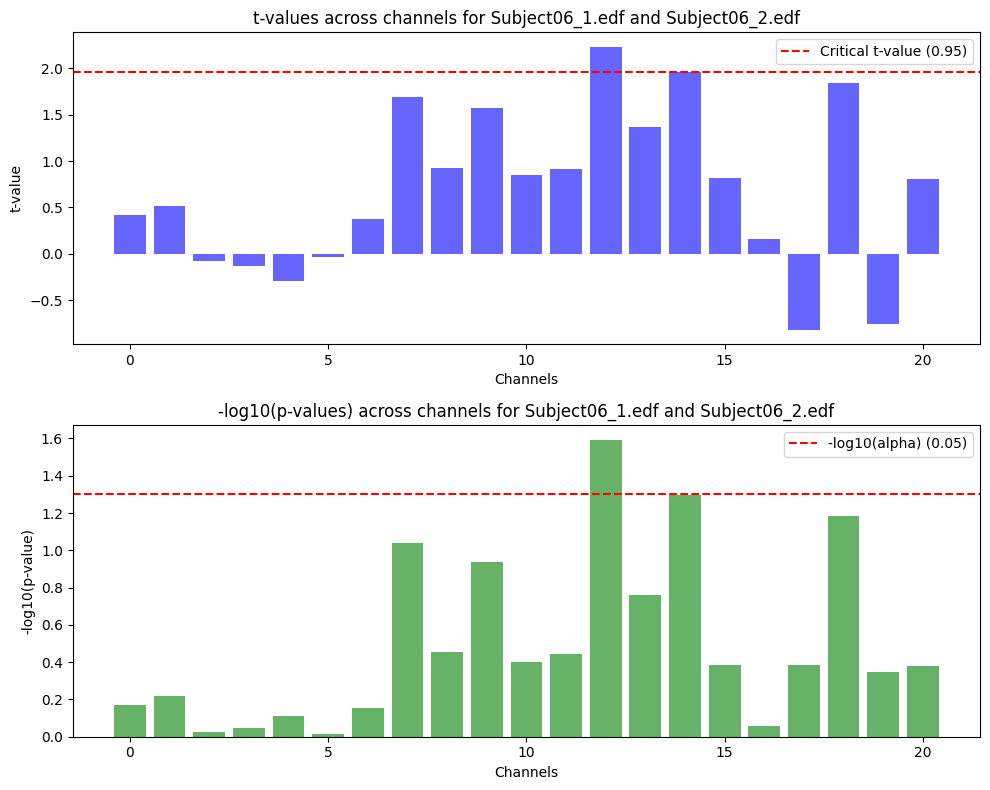

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject07_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject07_1.edf and Subject07_2.edf: 3


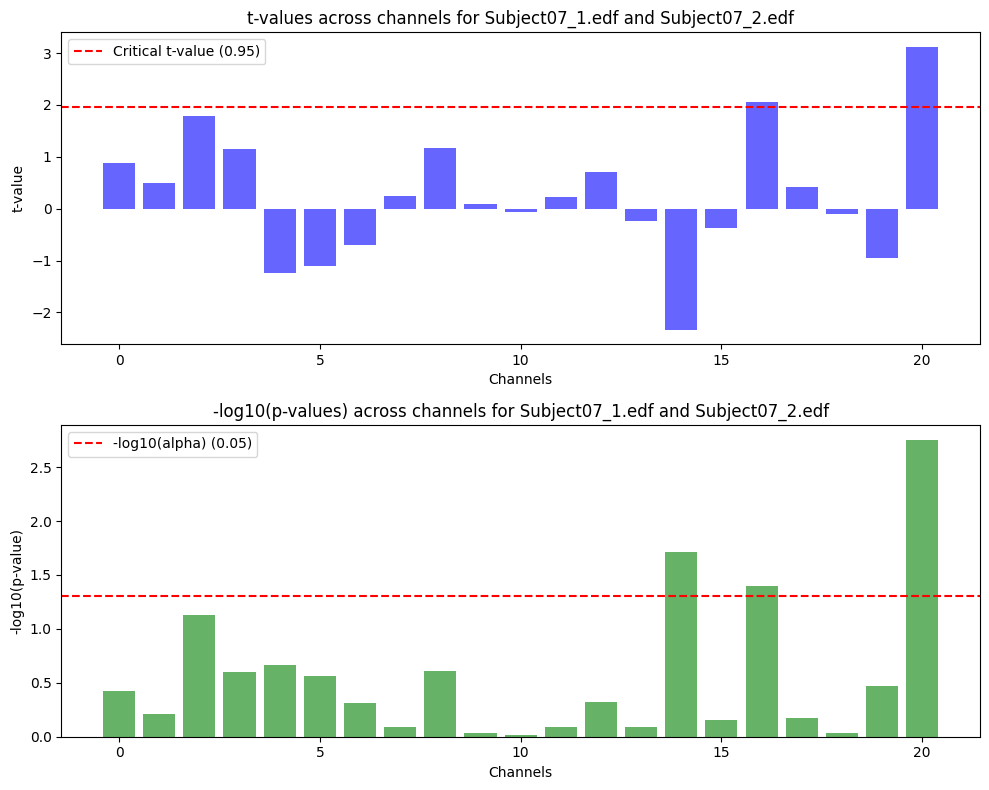

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject08_1.edf and Subject08_2.edf: 1


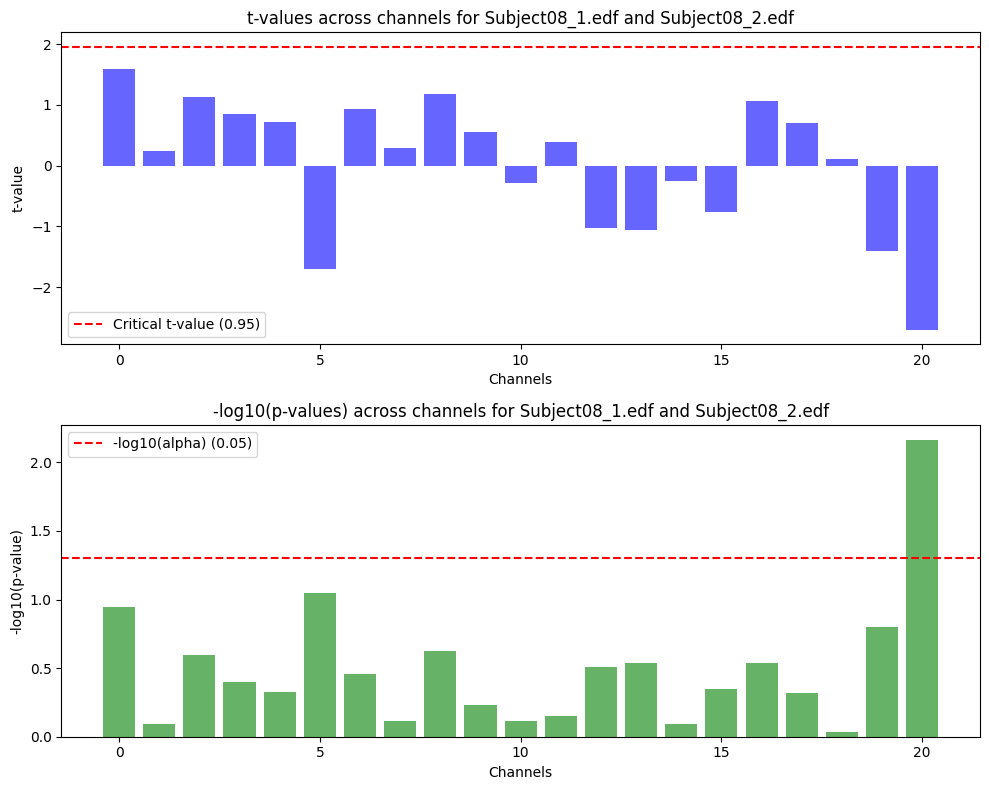

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject09_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject09_1.edf and Subject09_2.edf: 1


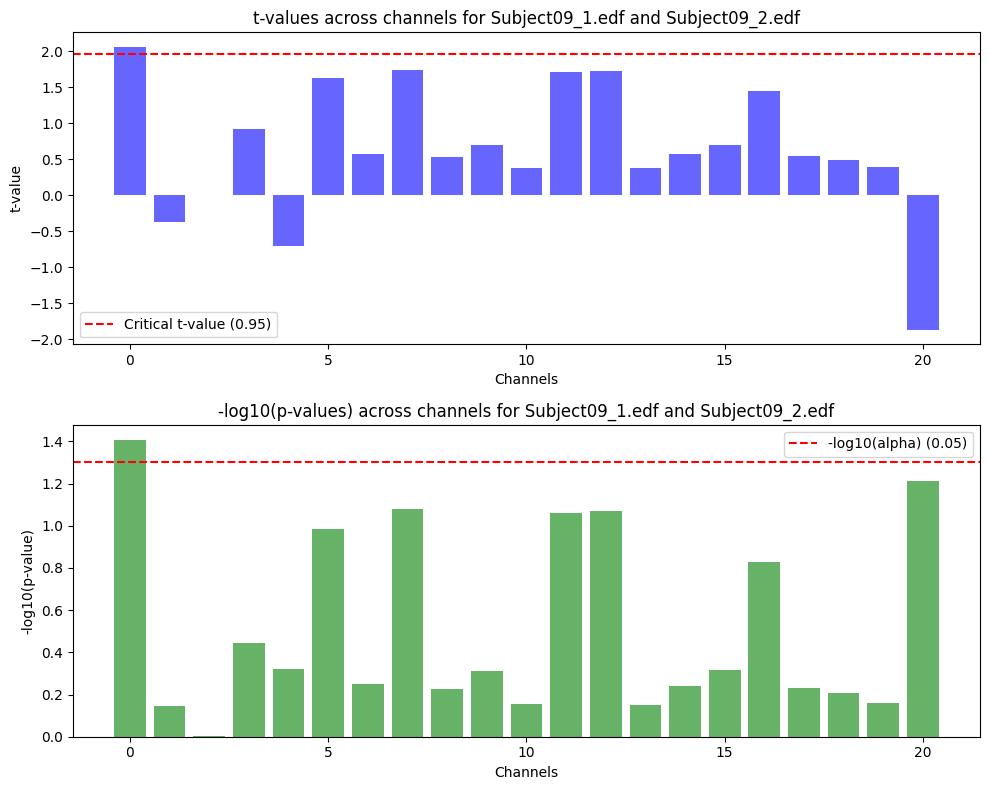

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject10_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 93999  =      0.000 ...   187.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject10_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject10_1.edf and Subject10_2.edf: 2


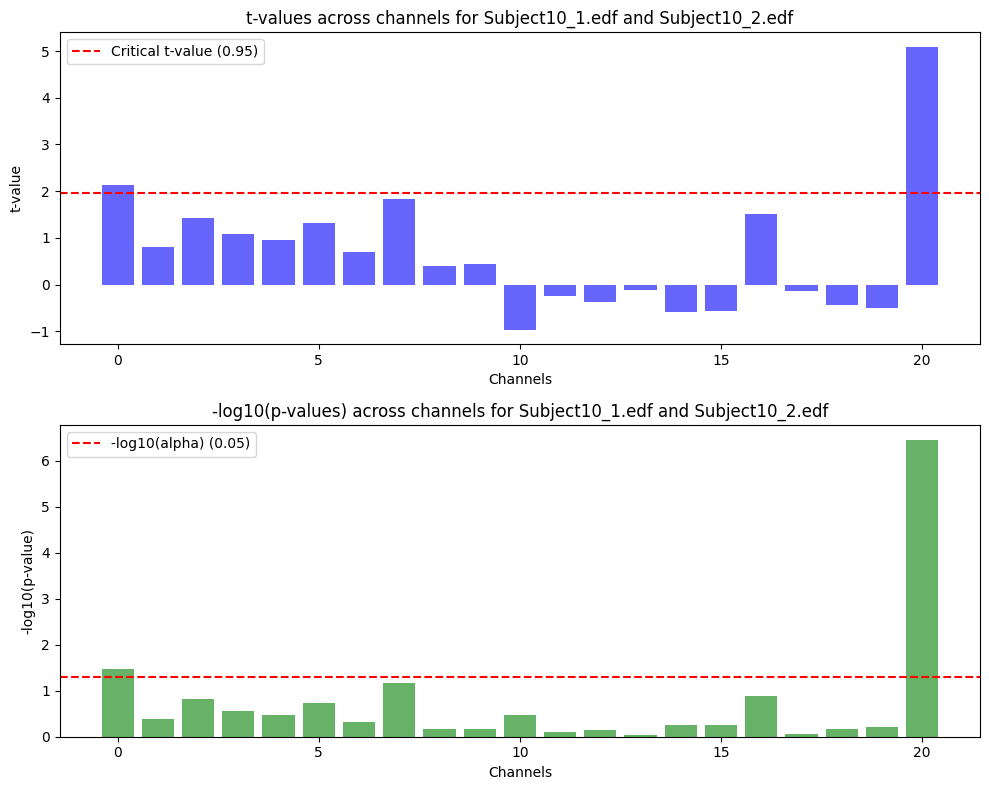

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject11_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject11_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject11_1.edf and Subject11_2.edf: 3


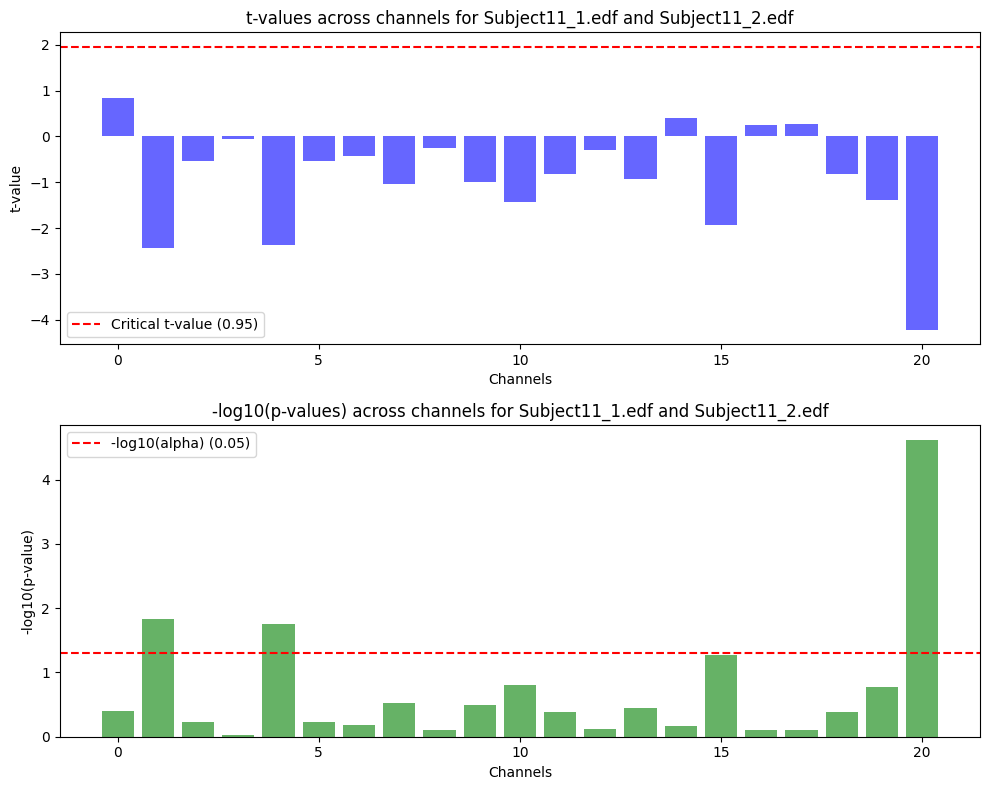

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject12_1.edf and Subject12_2.edf: 3


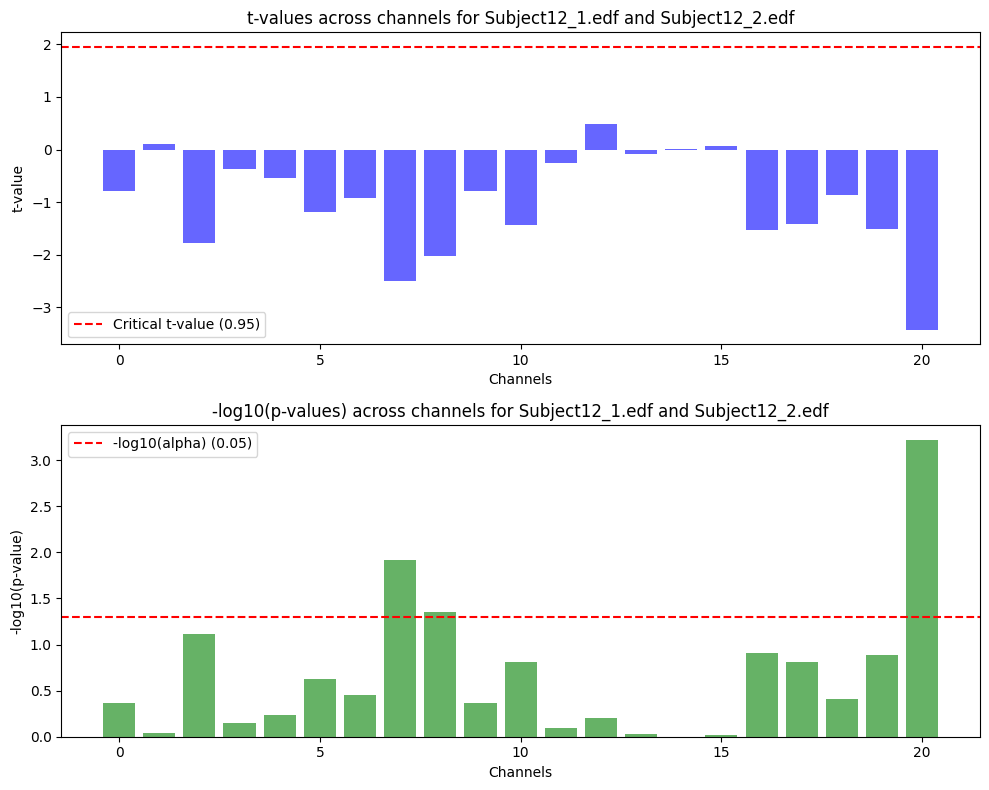

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject13_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject13_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject13_1.edf and Subject13_2.edf: 4


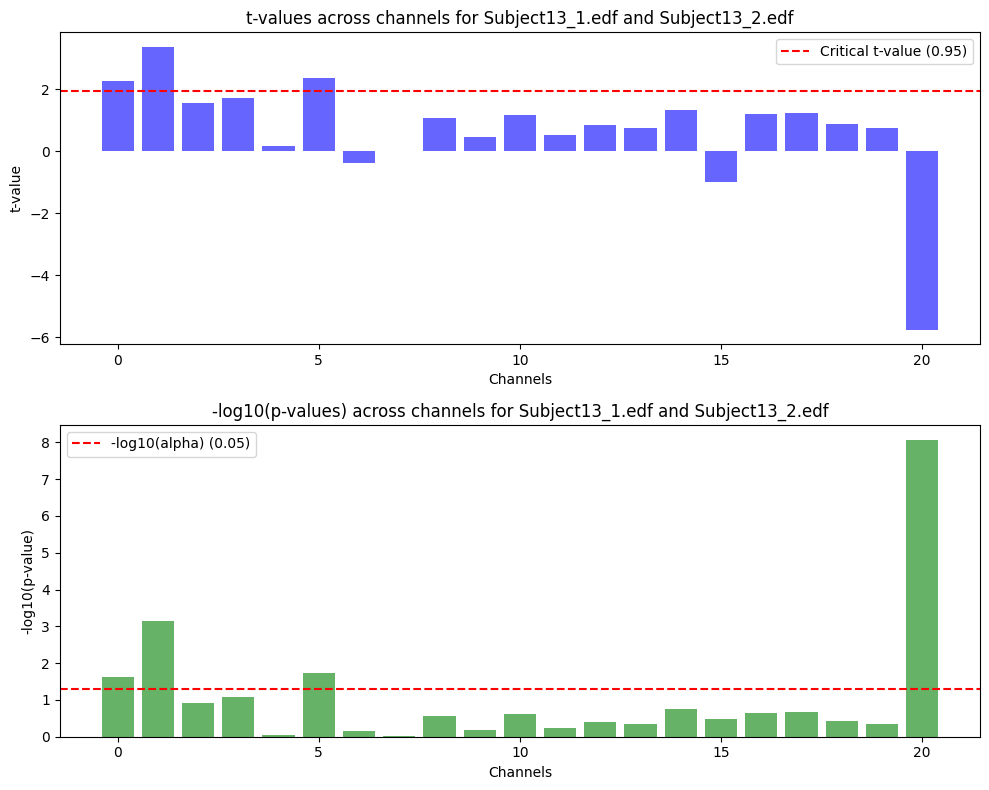

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject14_1.edf and Subject14_2.edf: 5


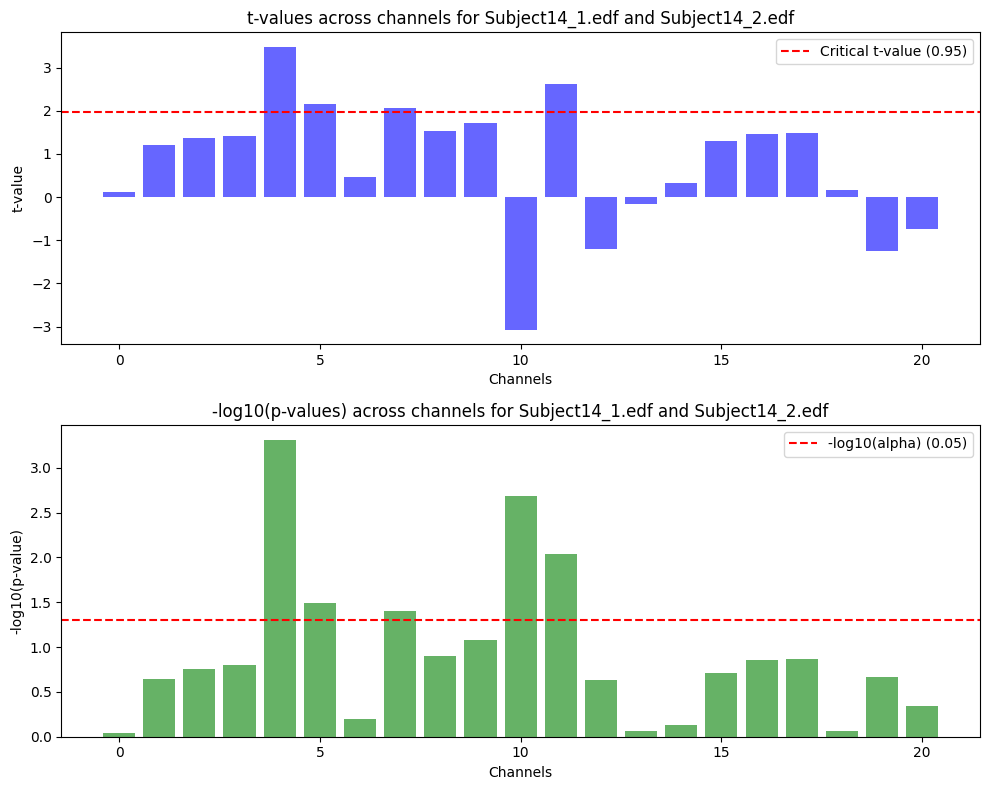

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject15_1.edf and Subject15_2.edf: 2


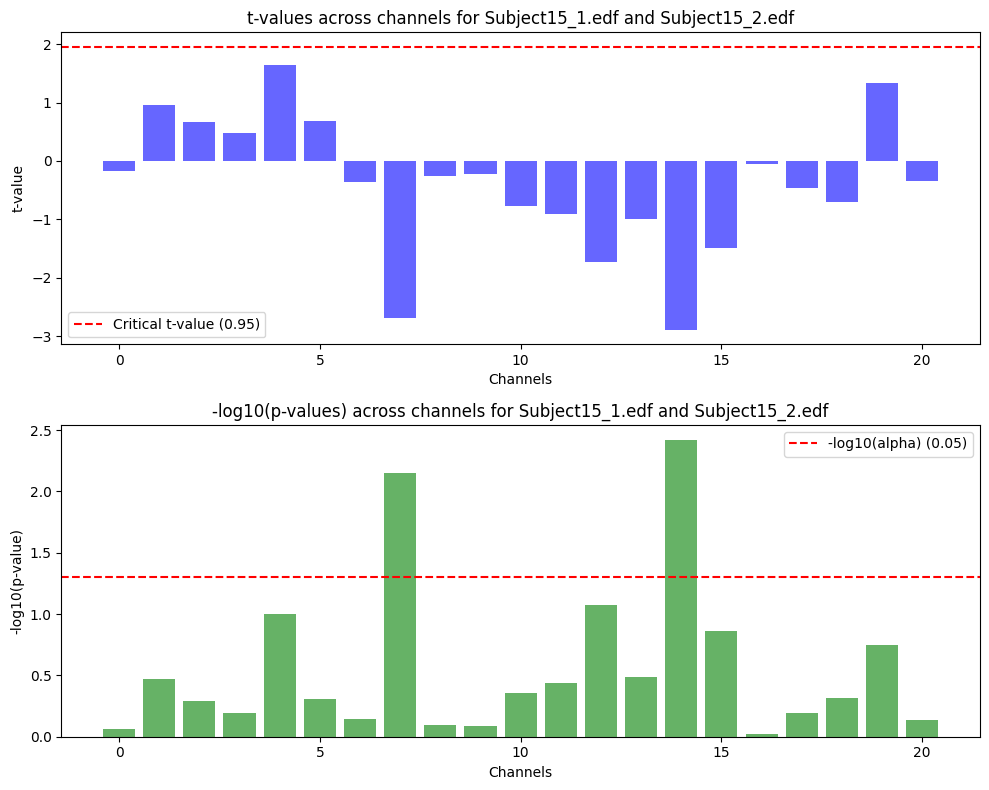

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject16_1.edf and Subject16_2.edf: 3


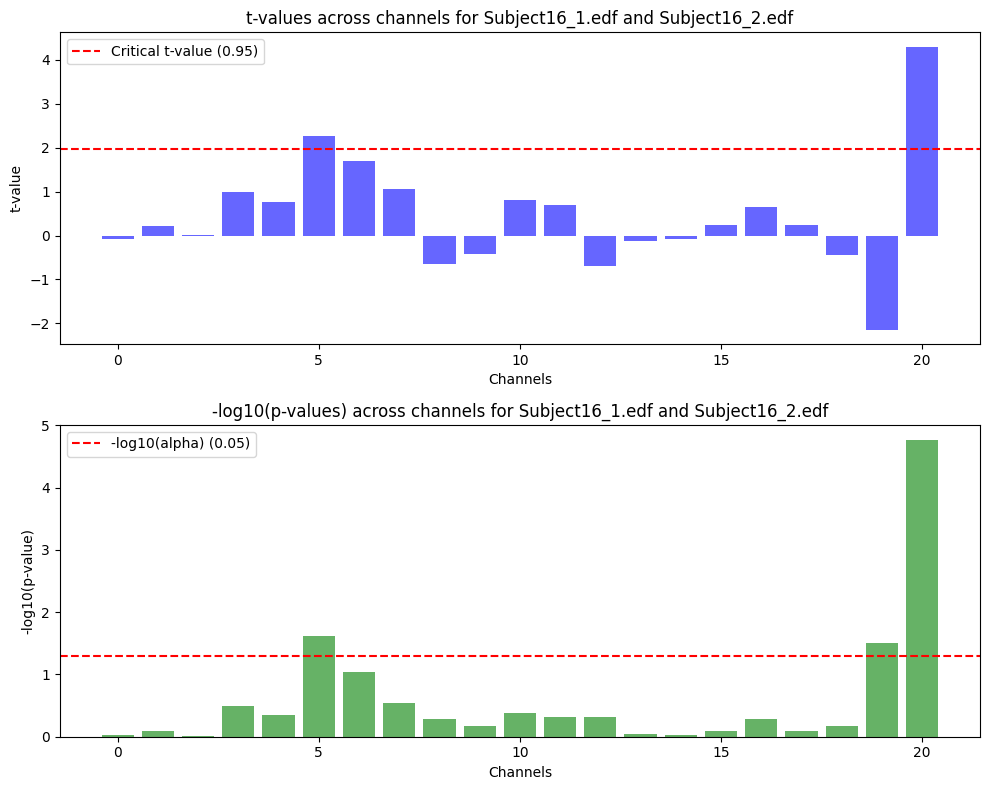

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject17_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject17_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject17_1.edf and Subject17_2.edf: 7


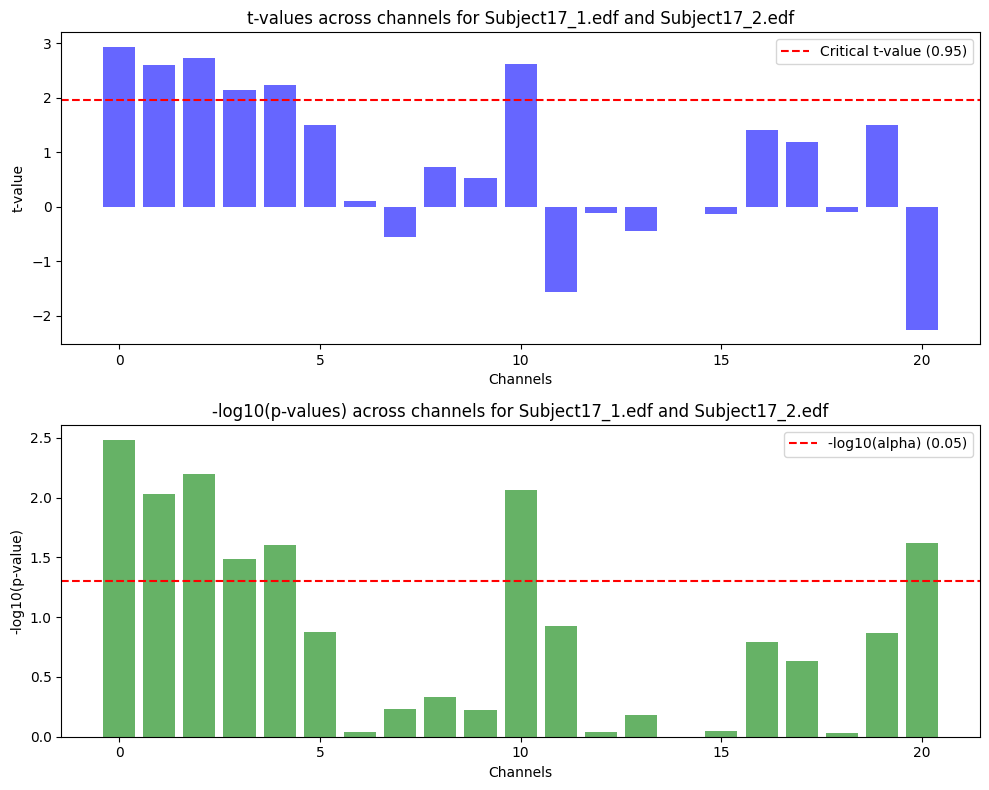

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject18_1.edf and Subject18_2.edf: 3


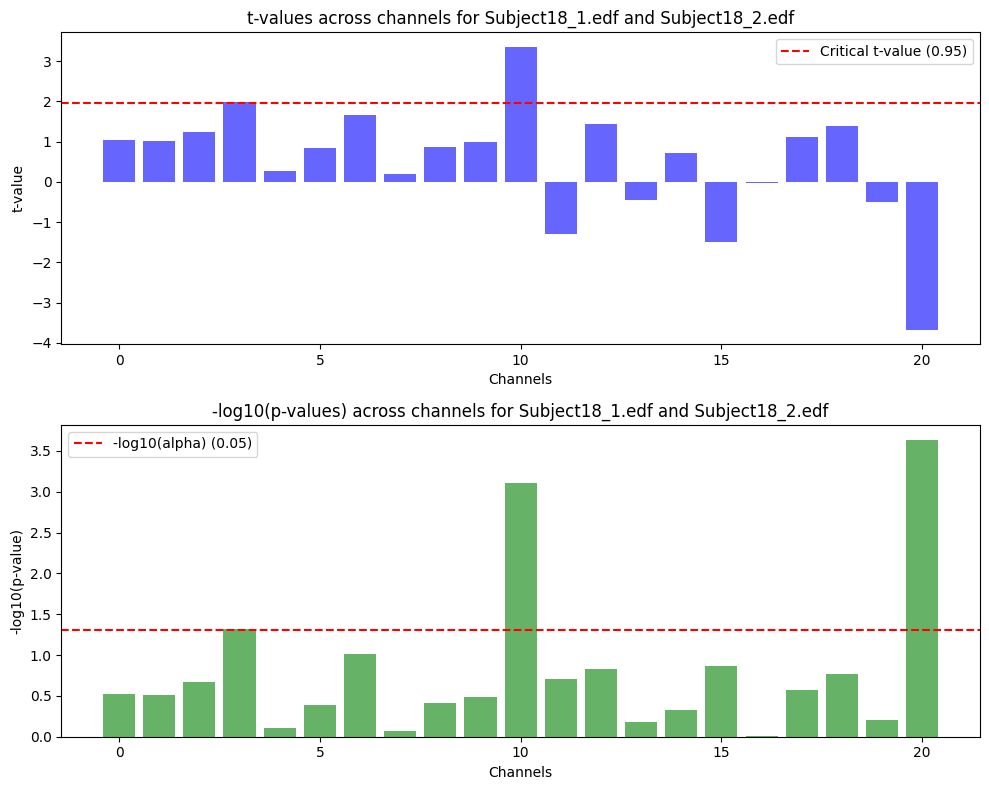

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject19_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject19_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject19_1.edf and Subject19_2.edf: 1


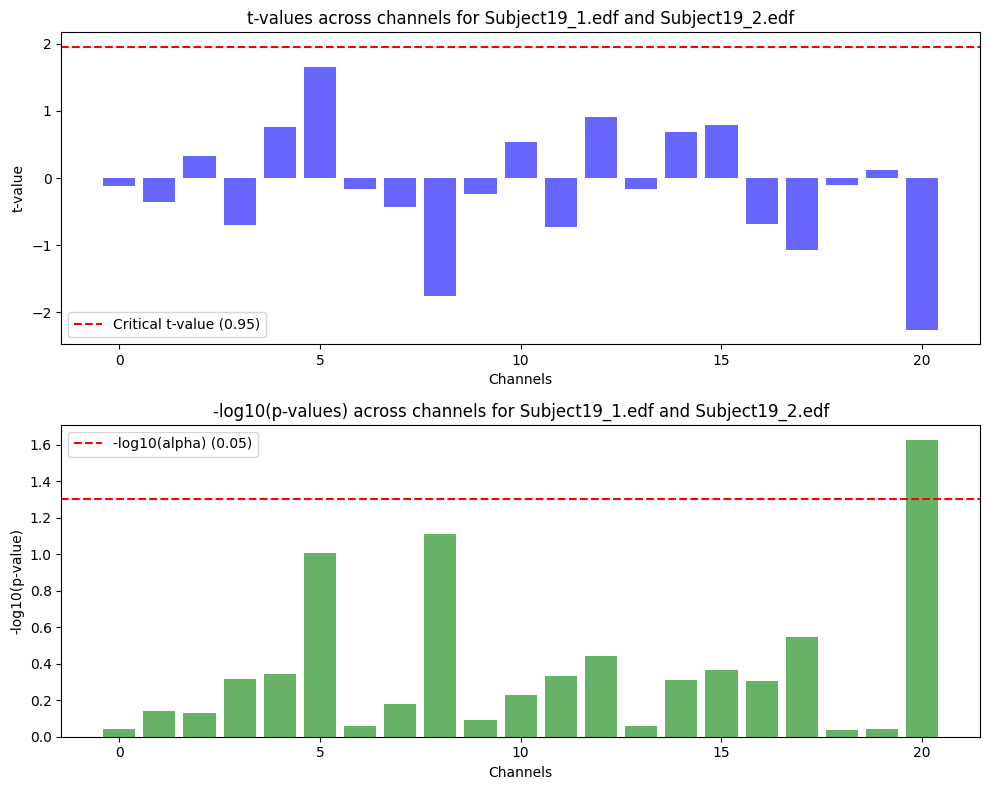

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject20_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject20_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject20_1.edf and Subject20_2.edf: 0


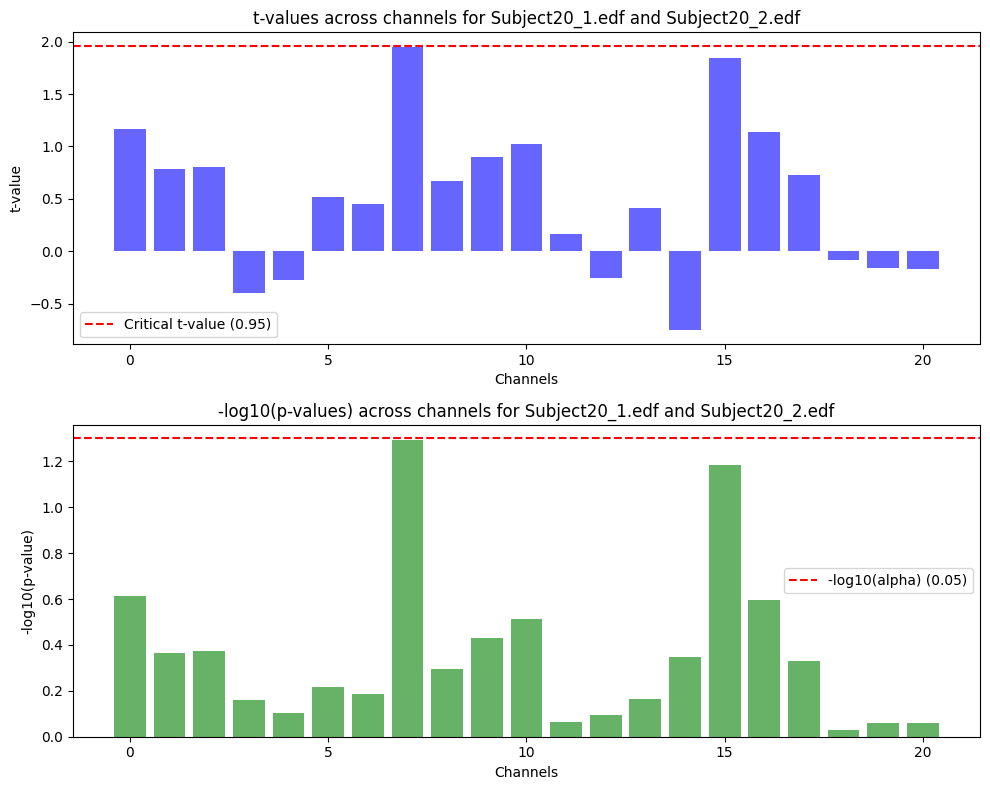

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject21_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject21_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject21_1.edf and Subject21_2.edf: 2


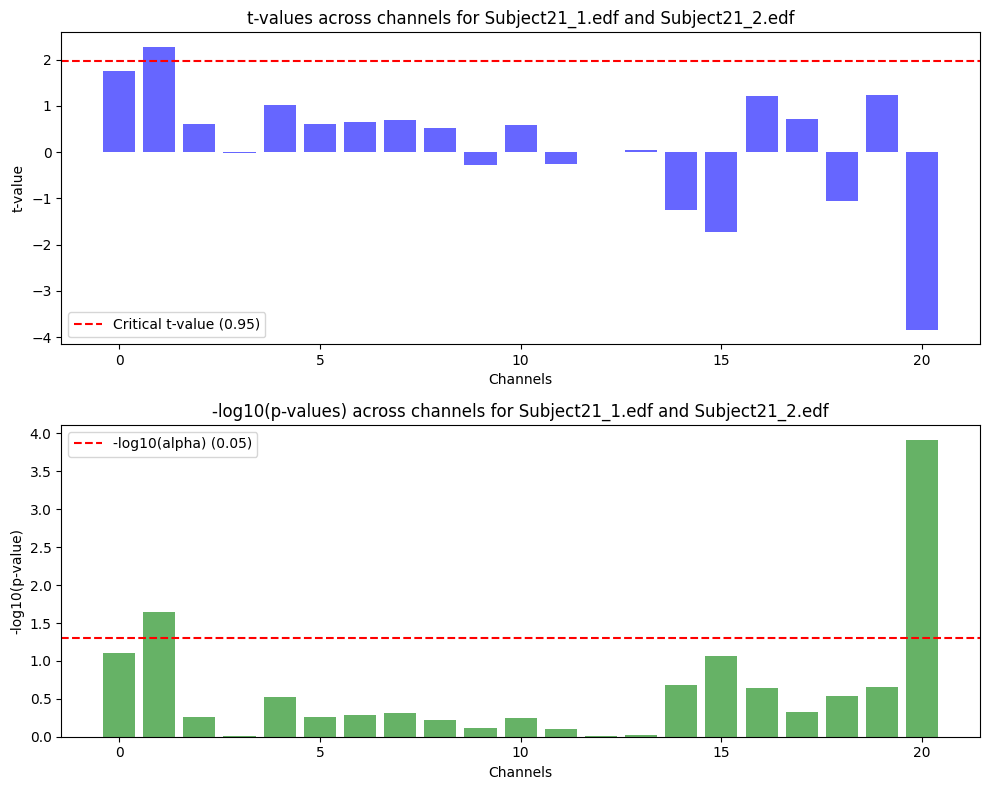

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject22_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject22_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject22_1.edf and Subject22_2.edf: 5


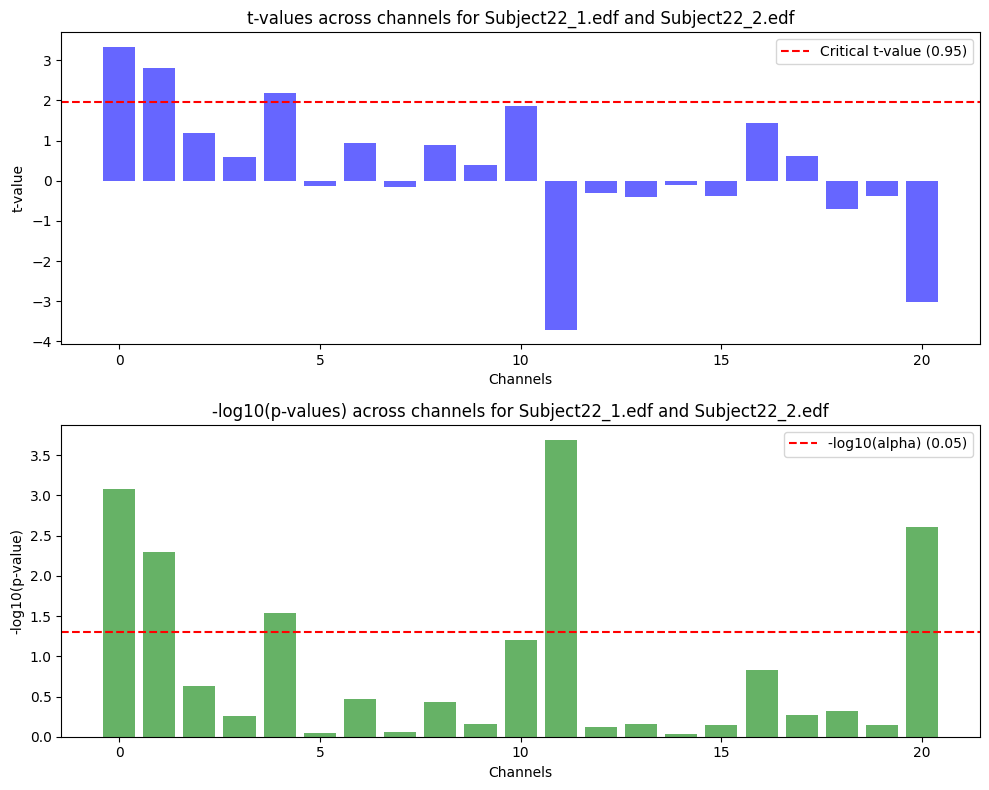

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject23_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject23_1.edf and Subject23_2.edf: 1


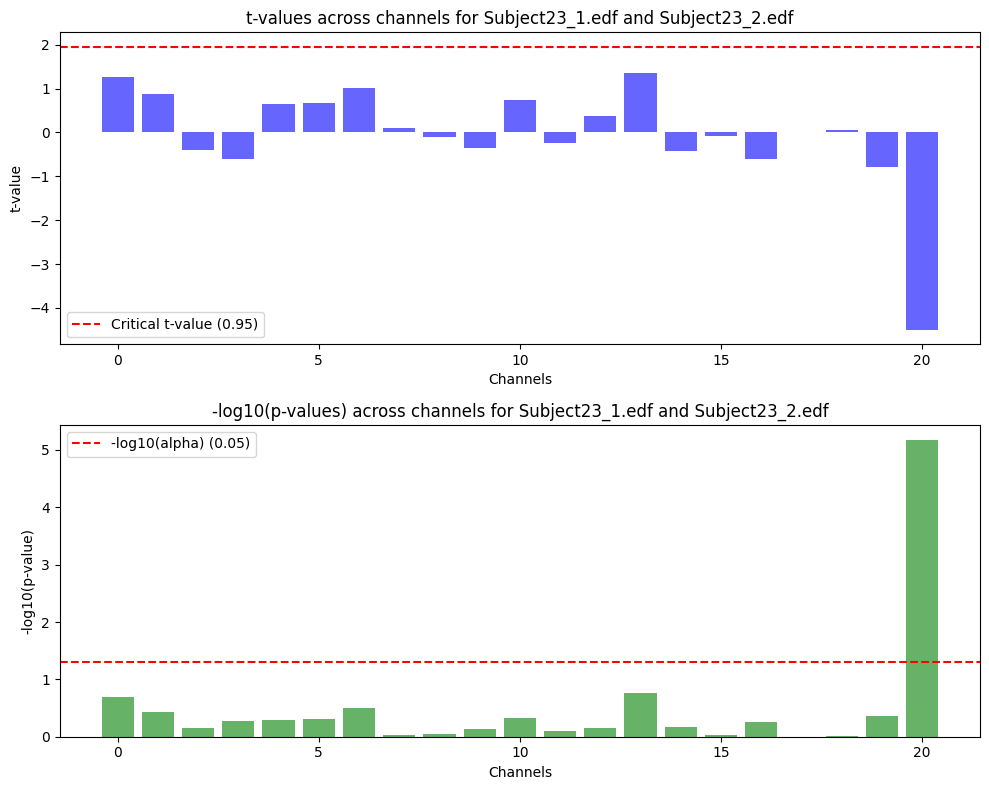

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject24_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject24_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject24_1.edf and Subject24_2.edf: 6


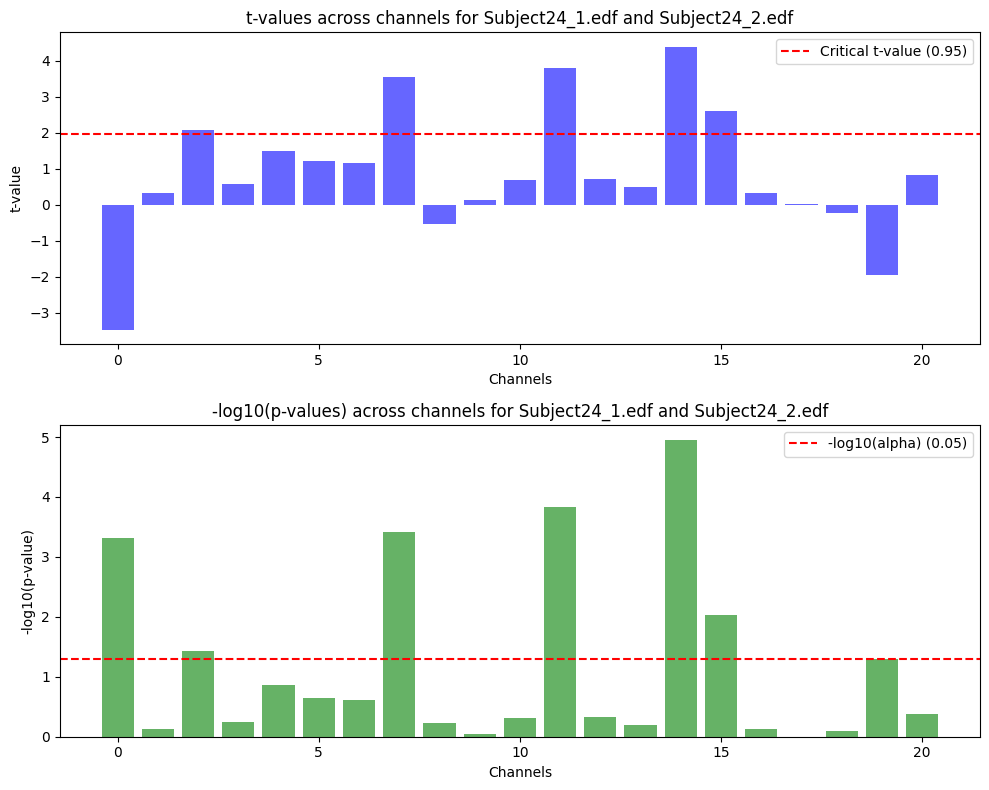

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject25_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject25_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject25_1.edf and Subject25_2.edf: 6


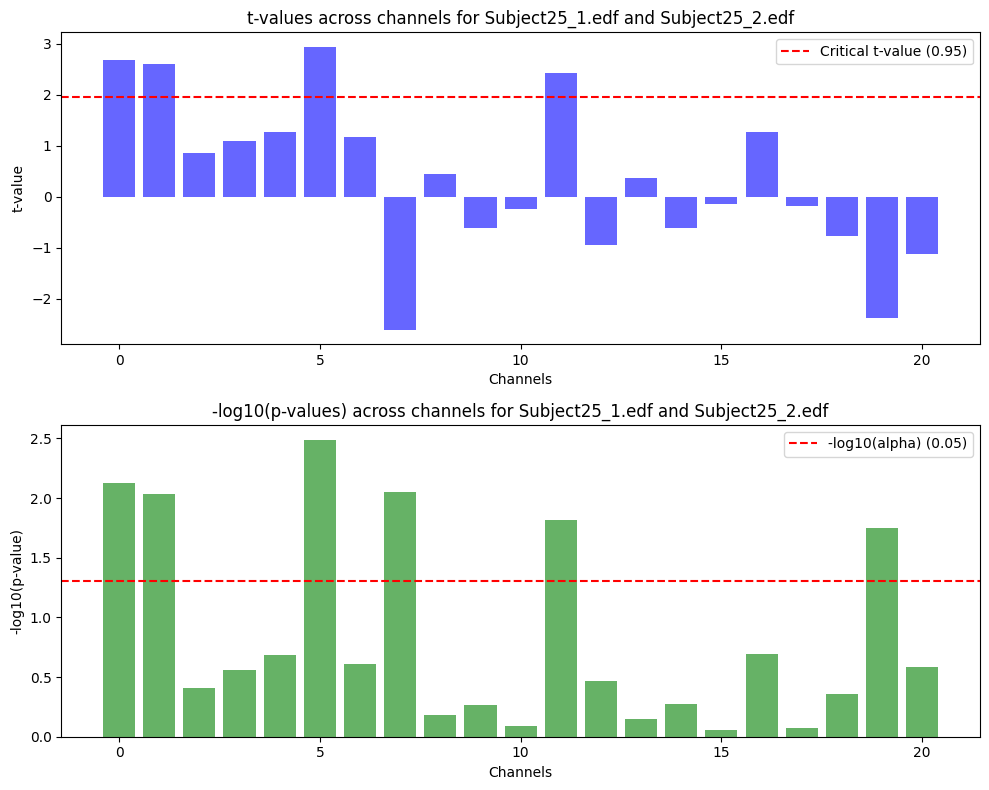

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject26_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject26_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject26_1.edf and Subject26_2.edf: 6


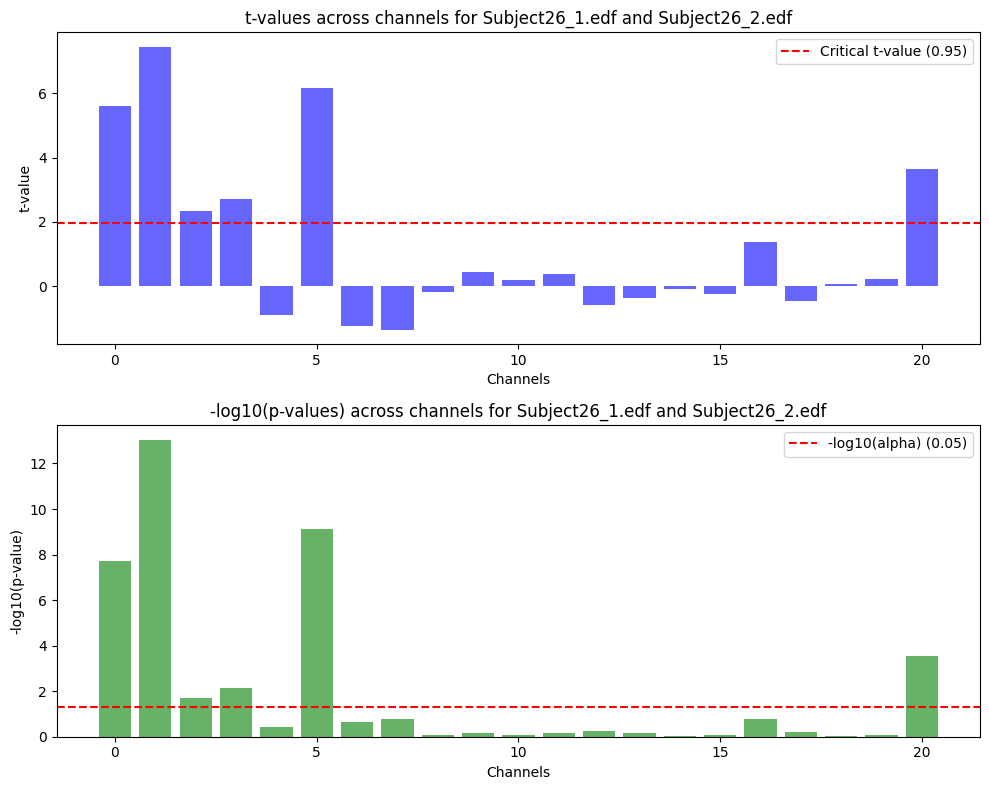

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject27_1.edf and Subject27_2.edf: 7


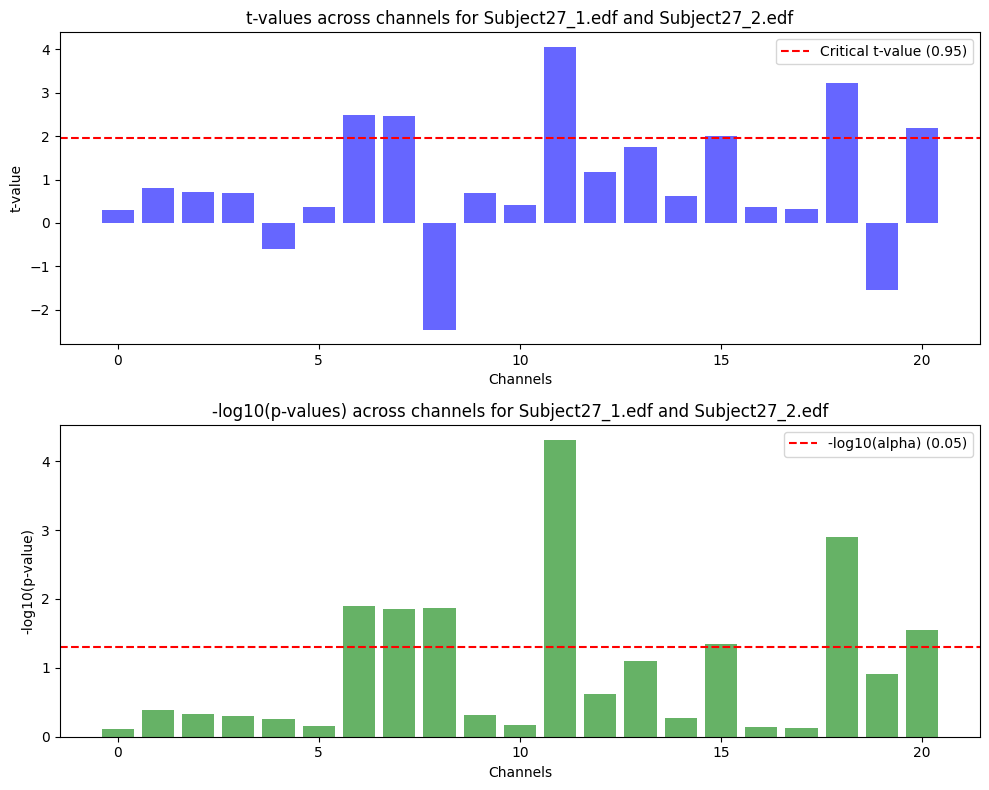

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject28_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject28_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject28_1.edf and Subject28_2.edf: 0


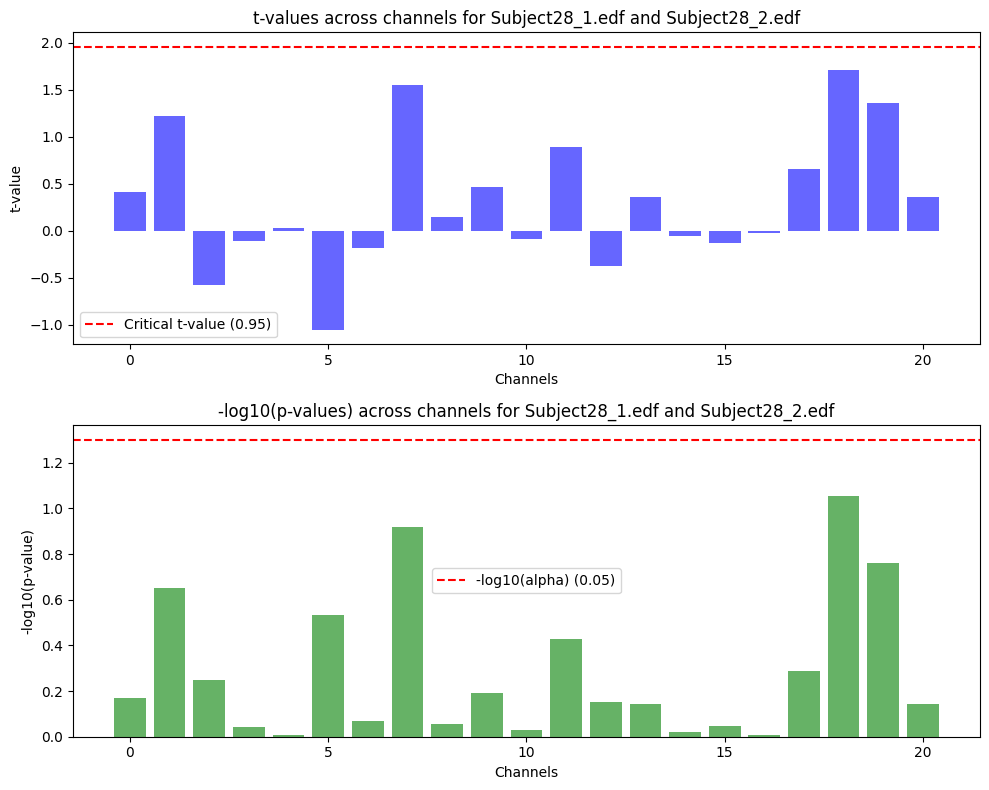

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject29_1.edf and Subject29_2.edf: 2


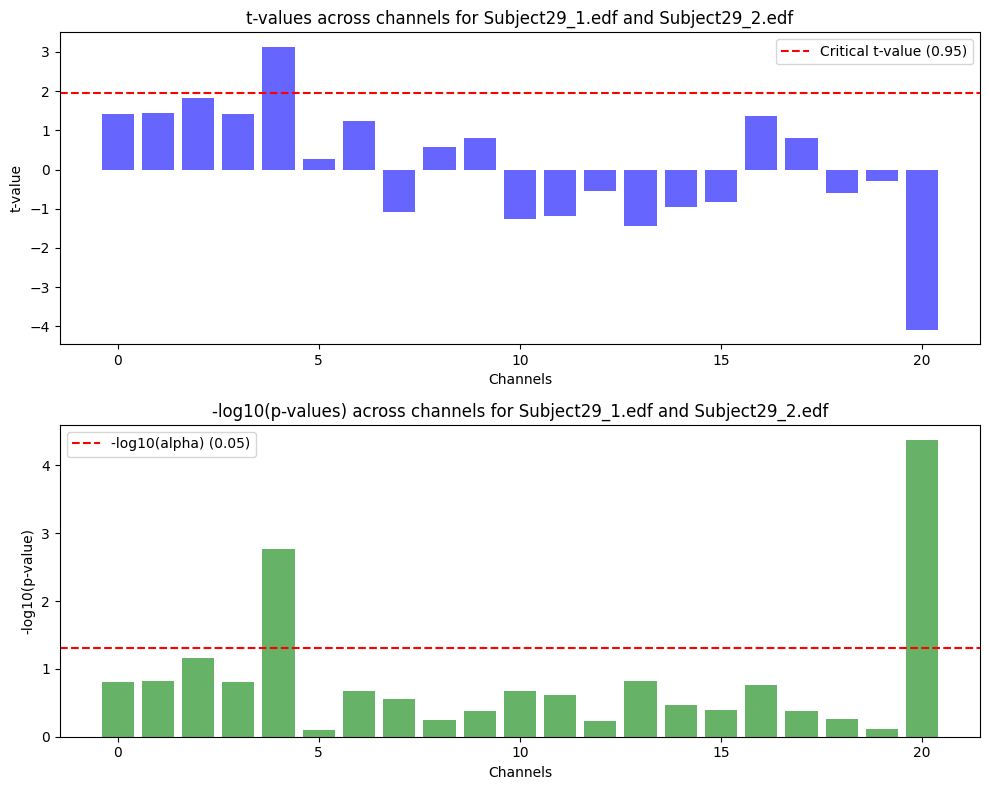

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject30_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject30_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject30_1.edf and Subject30_2.edf: 4


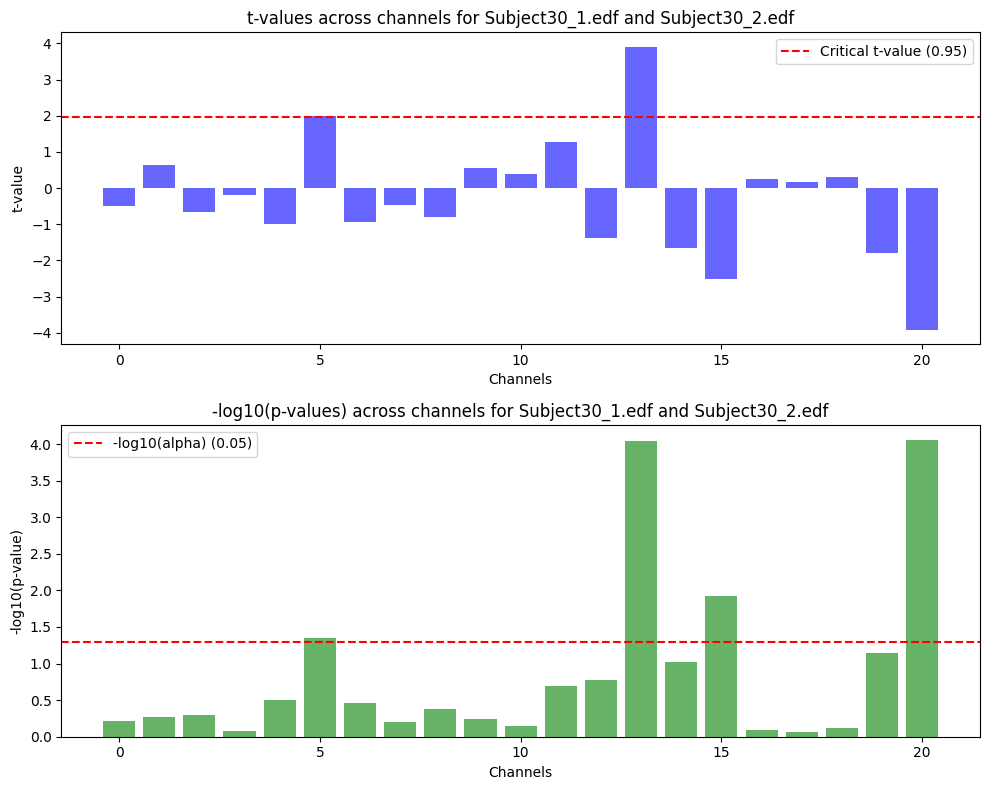

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 39999  =      0.000 ...    79.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject31_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject31_1.edf and Subject31_2.edf: 9


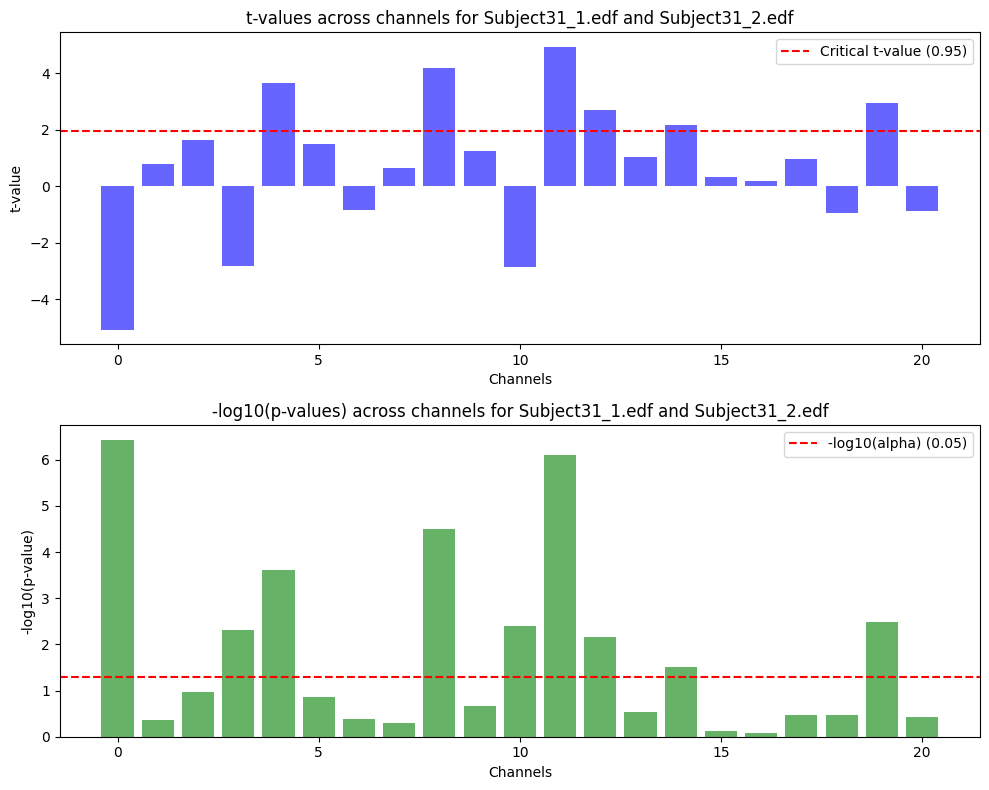

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject32_1.edf and Subject32_2.edf: 8


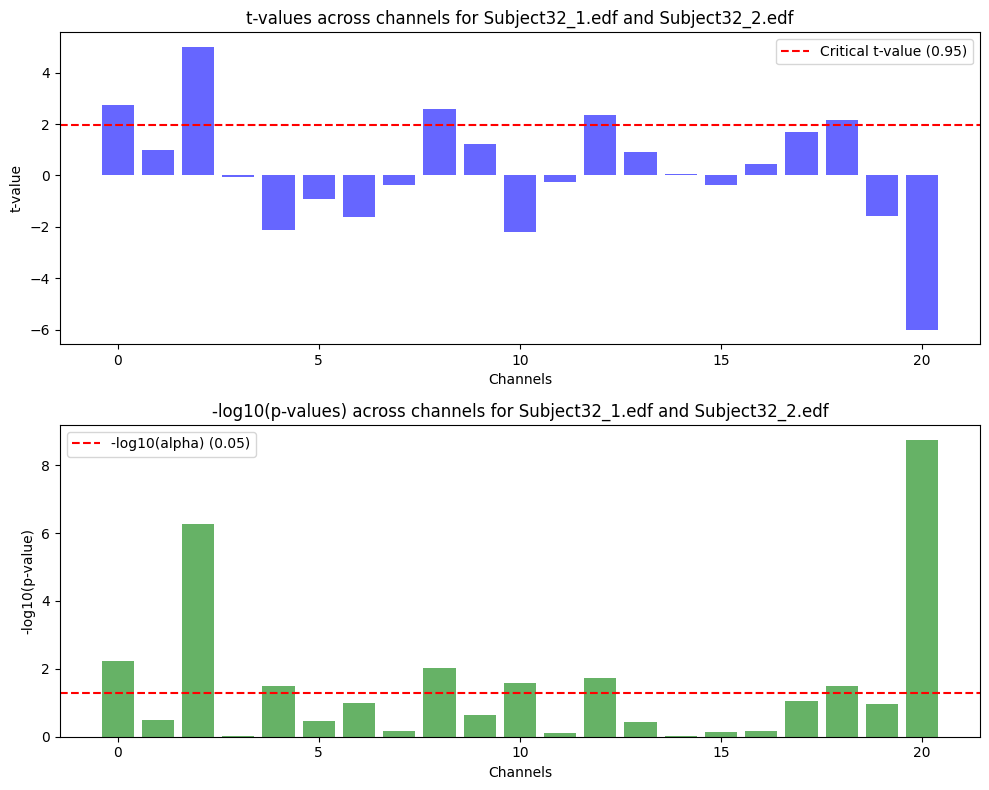

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject33_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject33_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject33_1.edf and Subject33_2.edf: 0


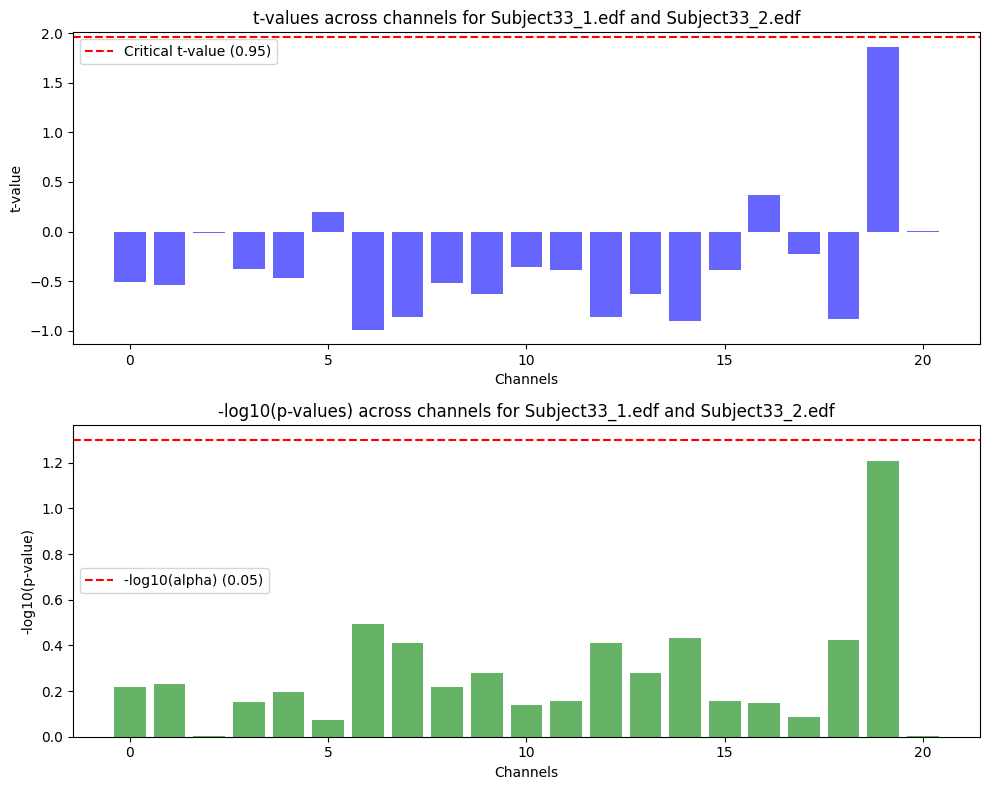

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject34_1.edf and Subject34_2.edf: 0


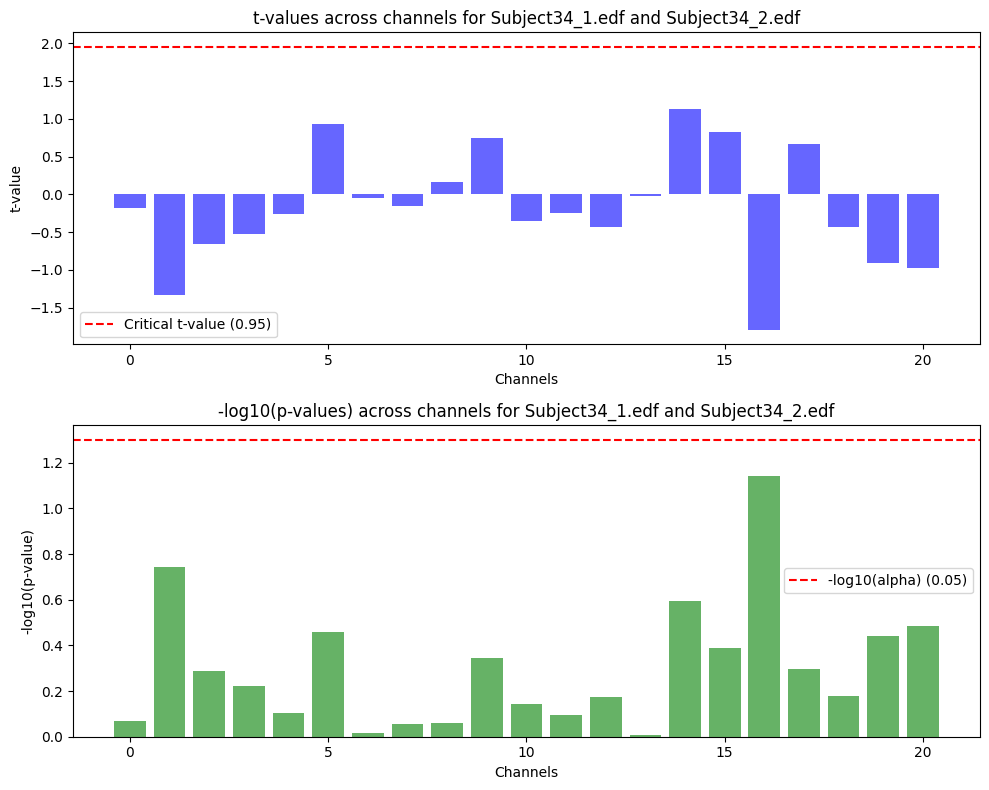

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject35_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Number of channels with significant differences in Subject35_1.edf and Subject35_2.edf: 1


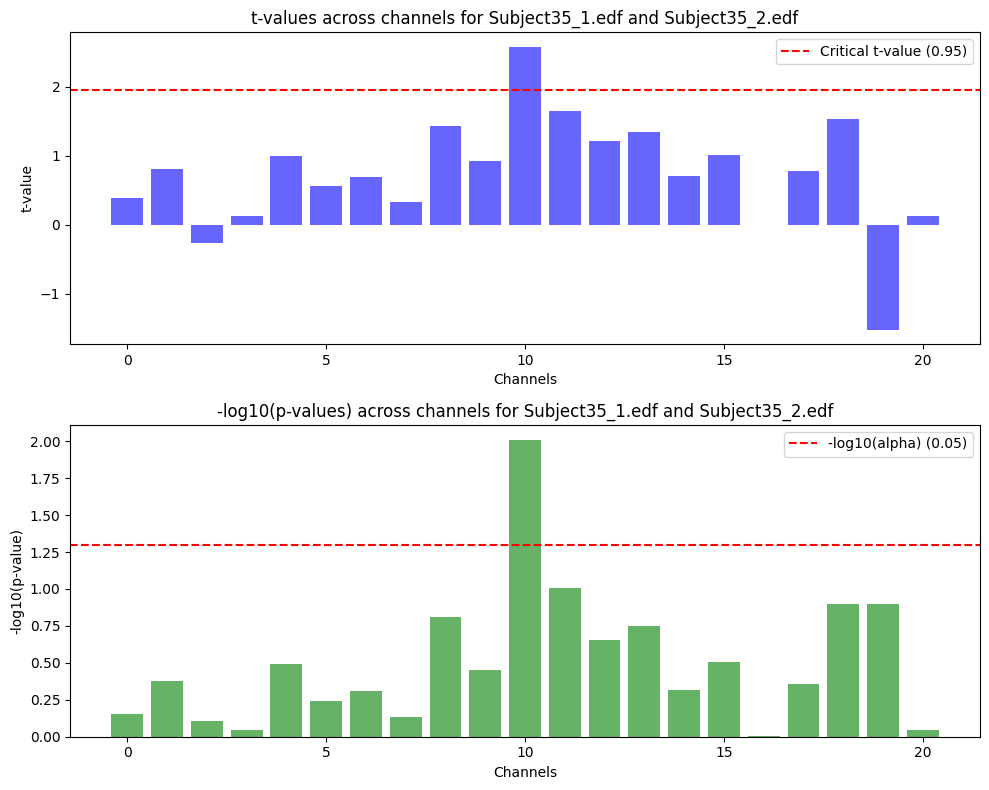

In [8]:
import os
import mne
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Define the path to the dataset on Google Drive
data_path = '/content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/'

# List all .edf files in the directory
edf_files = sorted([file for file in os.listdir(data_path) if file.endswith('.edf')])

# Iterate through each subject (assuming files are named Subject##_1.edf and Subject##_2.edf)
for i in range(0, len(edf_files), 2):
    edf_file_1 = edf_files[i]
    edf_file_2 = edf_files[i + 1]

    file_path_1 = os.path.join(data_path, edf_file_1)
    file_path_2 = os.path.join(data_path, edf_file_2)

    # Load the .edf files using MNE
    raw_1 = mne.io.read_raw_edf(file_path_1, preload=True)
    raw_2 = mne.io.read_raw_edf(file_path_2, preload=True)

    # Check the number of samples (assuming both have the same number of samples)
    num_samples = min(raw_1.get_data().shape[1], raw_2.get_data().shape[1])

    # Example conditions or groups (you need to define your own)
    condition_1 = raw_1.get_data()[:, :num_samples]  # Example data for condition 1 (before task)
    condition_2 = raw_2.get_data()[:, :num_samples]  # Example data for condition 2 (during task)

    # Perform t-test for each channel
    tvals, pvals = stats.ttest_rel(condition_1, condition_2, axis=1)

    # Count significant differences (assuming alpha = 0.05)
    alpha = 0.05
    significant_channels = np.sum(pvals < alpha)

    print(f"Number of channels with significant differences in {edf_file_1} and {edf_file_2}: {significant_channels}")

    # Visualization of t-values and p-values across channels
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot t-values
    axes[0].bar(np.arange(len(tvals)), tvals, color='b', alpha=0.6)
    axes[0].axhline(stats.t.ppf(1 - alpha/2, len(condition_1[0]) - 1), color='r', linestyle='--', label=f"Critical t-value ({1-alpha})")
    axes[0].set_xlabel('Channels')
    axes[0].set_ylabel('t-value')
    axes[0].set_title(f't-values across channels for {edf_file_1} and {edf_file_2}')
    axes[0].legend()

    # Plot p-values
    axes[1].bar(np.arange(len(pvals)), -np.log10(pvals), color='g', alpha=0.6)
    axes[1].axhline(-np.log10(alpha), color='r', linestyle='--', label=f"-log10(alpha) ({alpha})")
    axes[1].set_xlabel('Channels')
    axes[1].set_ylabel('-log10(p-value)')
    axes[1].set_title(f'-log10(p-values) across channels for {edf_file_1} and {edf_file_2}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


#3b. Implementing binary classification with EEGNet and Evaluating

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import mne
import numpy as np
import os

# Define the path to the dataset
data_path = '/content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0'

# Initialize lists to hold data and labels
eeg_data = []
labels = []

# Loop through files and preprocess
for file in os.listdir(data_path):
    if file.endswith('.edf'):
        # Load the EEG data using MNE
        raw = mne.io.read_raw_edf(os.path.join(data_path, file), preload=True)

        # Preprocess the data (e.g., filtering, epoching)
        raw.filter(1., 40., fir_design='firwin')
        epochs = mne.make_fixed_length_epochs(raw, duration=1.0, overlap=0.5)
        data = epochs.get_data()

        # Assume binary classification task (e.g., left vs right hand movement)
        # Here, we're creating synthetic labels for demonstration
        # Replace with actual labels from your dataset
        num_epochs = data.shape[0]
        label = 0 if 'left' in file else 1  # Example labeling logic

        # Append data and labels
        eeg_data.append(data)
        labels.extend([label] * num_epochs)

# Convert lists to numpy arrays
eeg_data = np.concatenate(eeg_data, axis=0)
labels = np.array(labels)

# Save the data to .npy files
np.save('eeg_data.npy', eeg_data)
np.save('labels.npy', labels)

print("EEG data and labels saved to 'eeg_data.npy' and 'labels.npy'.")

# Assuming data is stored in numpy arrays
# X: EEG data, y: labels
# X shape: (N, C, T)
# y shape: (N,)
X = np.load('eeg_data.npy')
y = np.load('labels.npy')

# Standardize the data
scaler = StandardScaler()
N, C, T = X.shape
X = X.reshape(N, -1)
X = scaler.fit_transform(X)
X = X.reshape(N, C, T)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


class EEGNet(nn.Module):
    def __init__(self, num_classes=2, Chans=64, Samples=128, dropoutRate=0.5):
        super(EEGNet, self).__init__()
        self.firstConv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, (Chans, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0),
            nn.Dropout(p=dropoutRate)
        )
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, (1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ELU(alpha=1.0),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropoutRate)
        )
        self.classify = nn.Linear(32 * (Samples // 32), num_classes)

    def forward(self, x):
        x = self.firstConv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = x.view(x.size(0), -1)
        x = self.classify(x)
        return x

# Define model, loss function, and optimizer
model = EEGNet(num_classes=2, Chans=C, Samples=T)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluate the model
model.eval()
with torch.no_grad():
    # Reshape X_test to match model's input requirements
    X_test = X_test.view(-1, 21, 500)  # Assuming 21 is height and 500 is width, and -1 is the batch size
    X_test = X_test.unsqueeze(1)  # Add channel dimension if needed

    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted)
    precision = precision_score(y_test, predicted, average='binary')
    recall = recall_score(y_test, predicted, average='binary')
    f1 = f1_score(y_test, predicted, average='binary')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_1.edf...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseli

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject24_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject22_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
339 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 339 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject13_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_2.edf...
EDF file detected


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject31_2.edf

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject05_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject22_1.edf...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject05_1.edf...
EDF file detected
Setting channel info structure...
Creating 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject33_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject19_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject30_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject23_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject10_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 93999  =      0.000 ...   187.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 375 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject30_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject11_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject33_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject19_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_1.edf...
EDF file detected
Setting channel info structure...
Creating 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject26_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject20_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject21_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject28_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject13_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject25_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject17_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject28_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject20_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject26_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject07_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseli

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_1.edf...
EDF file detected
Setting channel info structure...
Creating 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject35_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Reading 0 ... 39999  =      0.000 ...    79.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 159 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject04_2.edf...
EDF file detected
Setting channel info structure...
Creating 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG data and labels saved to 'eeg_data.npy' and 'labels.npy'.
Epoch 1/20, Loss: 0.01901644392792487
Epoch 2/20, Loss: 0.0002557242221680806
Epoch 3/20, Loss: 9.72991881553753e-05
Epoch 4/20, Loss: 4.954156417237822e-05
Epoch 5/20, Loss: 2.923013267440587e-05
Epoch 6/20, Loss: 1.844258438226192e-05
Epoch 7/20, Loss: 1.3558981153125757e-05
Epoch 8/20, Loss: 9.266555710812301e-06
Epoch 9/20, Loss: 6.575010707542282e-06
Epoch 10/20, Loss: 4.911436745237131e-06
Epoch 11/20, Loss: 3.766256569627381e-06
Epoch 12/20, Loss: 2.7817194165891124e-06
Epoch 13/20, Loss: 2.138355230367021e-06
Epoch 14/20, Loss: 1.6587031539559036e-06
Epoch 15/20, Loss: 1.3040511199933377e-06
Epoch 16/20, Loss: 1.0333140498314858e-06
Epoch 17/20, Loss: 7.739619096724937e-07
Epoch 18/20, Loss: 6.182240074273885e-07
Epoch 19/20, Loss: 4.77310570459024e-07
Epoch 20/20, Loss: 3.6380169145512876e-07
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


#3b. Implementing binary classification with VAE (Variational Autoencoder) and Evaluating

In [13]:
import mne
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Define the path to the dataset
data_path = "/content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0"

# Initialize lists to hold data and labels
eeg_data = []
labels = []

# Loop through files and preprocess
for file in os.listdir(data_path):
    if file.endswith('.edf'):
        # Load the EEG data using MNE
        raw = mne.io.read_raw_edf(os.path.join(data_path, file), preload=True)

        # Preprocess the data (e.g., filtering, epoching)
        raw.filter(1., 40., fir_design='firwin')
        epochs = mne.make_fixed_length_epochs(raw, duration=1.0, overlap=0.5)
        data = epochs.get_data()

        # Assume binary classification task (e.g., task vs rest)
        # Here, we're creating synthetic labels for demonstration
        # Replace with actual labels from your dataset
        num_epochs = data.shape[0]
        label = 0 if '_1' in file else 1  # Example labeling logic

        # Append data and labels
        eeg_data.append(data)
        labels.extend([label] * num_epochs)

# Convert lists to numpy arrays
eeg_data = np.concatenate(eeg_data, axis=0)
labels = np.array(labels)

# Save the data to .npy files
np.save('eeg_data.npy', eeg_data)
np.save('labels.npy', labels)

print("EEG data and labels saved to 'eeg_data.npy' and 'labels.npy'.")

# Load data
X = np.load('eeg_data.npy')
y = np.load('labels.npy')

# Standardize the data
scaler = StandardScaler()
N, C, T = X.shape
X = X.reshape(N, -1)
X = scaler.fit_transform(X)
X = X.reshape(N, C, T)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim=64*128, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(h3))
        return x_recon

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = C * T
model = VAE(input_dim=input_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def kld_loss(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def vae_loss(x_recon, x, mu, logvar):
    # Ensure x_recon and x are within [0, 1] range
    x = torch.clamp(x, 0, 1)
    x_recon = torch.clamp(x_recon, 0, 1)

    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = kld_loss(mu, logvar)
    return BCE + KLD

# Train the VAE
num_epochs = 2
batch_size = 32
train_dataset = TensorDataset(X_train.view(-1, input_dim), y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch)
        loss = vae_loss(x_recon, x_batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader.dataset)}')

# Extract features from the VAE
model.eval()
with torch.no_grad():
    X_train_encoded = model.encode(X_train.view(-1, input_dim).to(device))[0]
    X_test_encoded = model.encode(X_test.view(-1, input_dim).to(device))[0]

# Define classifier and optimizer
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.fc(x)  # Logits output
        return x

# Adjust input_dim in Classifier to match the latent_dim from VAE
latent_dim = 20
classifier = Classifier(input_dim=latent_dim).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the classifier
train_dataset_encoded = TensorDataset(X_train_encoded, y_train)
train_loader_encoded = DataLoader(train_dataset_encoded, batch_size=batch_size, shuffle=True)

num_epochs_classifier = 2
for epoch in range(num_epochs_classifier):
    classifier.train()
    running_loss = 0.0
    for inputs, labels in train_loader_encoded:
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs_classifier}, Loss: {running_loss/len(train_loader_encoded)}')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the classifier
classifier.eval()
with torch.no_grad():
    y_train_pred = classifier(X_train_encoded).argmax(dim=1).cpu().numpy()
    y_test_pred = classifier(X_test_encoded).argmax(dim=1).cpu().numpy()


# Compute metrics
accuracy = accuracy_score(y_test.cpu(), y_test_pred)
precision = precision_score(y_test.cpu(), y_test_pred)
recall = recall_score(y_test.cpu(), y_test_pred)
f1 = f1_score(y_test.cpu(), y_test_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject24_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_1.edf...
EDF file detected
Setting channel info structure...
Creating 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject01_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-ca

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject22_2.edf...
EDF file detected


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject04_1.edf

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
339 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 339 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject13_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject35_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject31_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject05_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject07_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject22_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject05_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject10_2.edf

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject19_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject30_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject23_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject10_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 93999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 375 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject30_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject25_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject33_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject29_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject26_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject34_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s



FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject20_2.edf...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject18_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject09_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject21_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject28_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject13_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject02_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject25_1.edf...
EDF file detected
Setting channel info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject17_2.edf...
EDF file detected
Setting chan

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject06_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject28_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject09_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject26_1.edf...
EDF file detected


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject32_2.edf

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject08_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject07_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject23_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject14_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject16_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject12_1.edf...
EDF file detected
Setting channel info structure...
Creating 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject15_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject06_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject03_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject35_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject31_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 39999  =      0.000 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 159 events and 500 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject04_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject27_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 90999  =      0.000 ...   181.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
363 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 363 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


0 bad epochs dropped
Extracting EDF parameters from /content/drive/My Drive/eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 30999  =      0.000 ...    61.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Not setting metadata
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 500 ori

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


EEG data and labels saved to 'eeg_data.npy' and 'labels.npy'.
Epoch 1/2, Loss: 13490.96341168439
Epoch 2/2, Loss: 5447.280944824219
Epoch 1/2, Loss: 0.6700355184988843
Epoch 2/2, Loss: 0.5770775539179643
Accuracy: 0.7457
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
